# **Proyecto Título - Modelo de Pricing y Sistema Recomendador**

Con el objetivo de posicionar a XX como un actor más competitivo y con presencia estable en el mercado recientemente abierto tras el fin del monopolio de la adquirente Transbank, desarrollamos este proyecto. El desafío exige una mirada integral que considere las fuertes restricciones regulatorias, la diversidad de actores con interacciones complejas y el acceso limitado a información confiable y con volumen suficiente.

El primer paso consiste en recopilar exhaustivamente todas las fuentes disponibles dentro de la organización, consolidando tablas internas y registros históricos. A partir de esa base, modelamos el comportamiento del mercado: analizamos la estructura de costos del rubro, las características de la competencia y los distintos perfiles de comercios. Finalmente, contrastamos las estimaciones del modelo con una evaluación rigurosa de incertidumbre que permita respaldar decisiones de pricing sólidas y accionables.

## **Exploración inicial de datos de pricing**

In [45]:
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

pd.options.display.float_format = "{:,.2f}".format

BASE_PATH = Path("base_con_sin_trx_cleaned.csv")
DATA_DIR = Path("data")
RAW_TERMINAL_FILE = DATA_DIR / "terminales_con_sin_transacciones_mensual.csv"
PRICING_FILE = DATA_DIR / "precios_actuales_klap.xlsx"
COMPETITOR_FILE = DATA_DIR / "precios_Competidores.xlsx"
BRAND_COST_FILE = DATA_DIR / "costos_marca_25_1.xlsx"
INTERCHANGE_FILE = DATA_DIR / "Tasa_Intercambio_Chile_Visa_y_Mastercard.csv"

La tabla principal, `base_con_y_sin`, reúne las transacciones realizadas por cada comercio en cada periodo y local. Incluye tanto clientes activos como comercios antiguos, junto con la duración de la relación y variables descriptivas clave.

### Lectura de la tabla y limpieza

In [46]:
df = pd.read_csv(BASE_PATH, low_memory=False)

print(f"Filas: {len(df):,}")
print(f"Columnas: {len(df.columns)}")

print(df.dtypes.head(10))

print(
    "\n Vista previa de la tabla base con transacciones mensuales por terminal y comercio:\n"
)
display(df.head())


def parse_numeric_date(series):
    numeric = pd.to_numeric(series, errors="coerce")
    result = pd.Series(pd.NaT, index=series.index, dtype="datetime64[ns]")
    valid = numeric.notna()
    if valid.any():
        numeric_int = numeric[valid].round().astype("Int64")
        formatted = numeric_int.astype(str).str.zfill(8)
        parsed = pd.to_datetime(formatted, format="%Y%m%d", errors="coerce")
        result.loc[valid] = parsed.values
    return result


df["periodo"] = pd.to_datetime(
    df["periodo"] + "-01", format="%Y-%m-%d", errors="coerce"
).dt.to_period("M")
df["fecha_instalacion"] = parse_numeric_date(df["fecha_instalacion"])
df["fecha_baja"] = parse_numeric_date(df["fecha_baja"])

value_cols = [c for c in df.columns if c.startswith("qtrx_") or c.startswith("monto_")]
for col in value_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0)

qtrx_cols = [c for c in df.columns if c.startswith("qtrx_") and c != "qtrx_total"]
monto_cols = [c for c in df.columns if c.startswith("monto_") and c != "monto_clp"]

df["qtrx_total"] = pd.to_numeric(df["qtrx_total"], errors="coerce").fillna(0)
df["monto_clp"] = pd.to_numeric(df["monto_clp"], errors="coerce").fillna(0)
if df["qtrx_total"].eq(0).all():
    df["qtrx_total"] = df[qtrx_cols].sum(axis=1)
if df["monto_clp"].eq(0).all():
    df["monto_clp"] = df[monto_cols].sum(axis=1)

print(
    "\n Vista previa de las columnas procesadas (fechas y métricas de transacciones):\n"
)
display(
    df[["periodo", "fecha_instalacion", "fecha_baja", "qtrx_total", "monto_clp"]].head()
)

summary = {
    "filas": len(df),
    "periodo_min": df["periodo"].min(),
    "periodo_max": df["periodo"].max(),
    "meses_distintos": df["periodo"].nunique(),
    "comercios_distintos": df["rut_comercio"].nunique(),
    "locales_distintos": df["codigo_local"].nunique(),
    "terminales_distintos": df["numero_terminal"].nunique(),
    "total_transacciones": int(df["qtrx_total"].sum()),
    "total_monto_clp": df["monto_clp"].sum(),
    "share_filas_monto_cero": df["monto_clp"].eq(0).mean(),
}
summary = pd.DataFrame.from_dict(summary, orient="index", columns=["Valor"])
print("\n Resumen del dataset de terminales \n")
display(summary)


Filas: 1,398,340
Columnas: 36
periodo                 object
rut_comercio            object
codigo_local             int64
numero_terminal          int64
estado_terminal         object
tecnologia_instalar     object
fecha_instalacion      float64
fecha_baja             float64
pos_con_trx              int64
modelo_equipo           object
dtype: object

 Vista previa de la tabla base con transacciones mensuales por terminal y comercio:



,periodo,rut_comercio,codigo_local,numero_terminal,estado_terminal,tecnologia_instalar,fecha_instalacion,fecha_baja,pos_con_trx,modelo_equipo,...,monto_vale_electronico,qtrx_ripley,monto_ripley,qtrx_hites,monto_hites,qtrx_adquriencia_general,monto_adquriencia_general,margen_bruto_adquirencia,qtrx_total,monto_clp
0,2024-01,8123393-4,639,631,BAJA_POR_PERDIDA,POS GPRS,"20,080,729.00",NaN,0,NaN,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,2024-01,13453225-4,372,364,HABILITADO,POS GPRS,"20,080,623.00",NaN,1,NaN,...,0.00,0.00,0.00,0.00,0.00,"3,326.00","14,914,534.00",0.00,"6,652.00","29,829,068.00"
2,2024-01,7101190-9,560,552,HABILITADO,POS GPRS,"20,080,708.00",NaN,1,NaN,...,0.00,0.00,0.00,0.00,0.00,502.00,"2,421,660.00",0.00,"1,004.00","4,843,320.00"
3,2024-01,12665285-2,593,585,BAJA_POR_PERDIDA,POS GPRS,"20,080,717.00",NaN,0,NaN,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,2024-01,6402350-0,711,703,HABILITADO,POS GPRS,"20,080,822.00",NaN,1,NaN,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00



 Vista previa de las columnas procesadas (fechas y métricas de transacciones):



,periodo,fecha_instalacion,fecha_baja,qtrx_total,monto_clp
0,2024-01,2008-07-29,NaT,0.00,0.00
1,2024-01,2008-06-23,NaT,"6,652.00","29,829,068.00"
2,2024-01,2008-07-08,NaT,"1,004.00","4,843,320.00"
3,2024-01,2008-07-17,NaT,0.00,0.00
4,2024-01,2008-08-22,NaT,0.00,0.00



 Resumen del dataset de terminales 



,Valor
filas,1398340
periodo_min,2024-01
periodo_max,2024-12
meses_distintos,12
comercios_distintos,75282
locales_distintos,98872
terminales_distintos,141756
total_transacciones,1779746258
total_monto_clp,"17,160,132,763,231.00"
share_filas_monto_cero,0.84


### Estadísticas generales del dataset

In [47]:
estado_counts = df["estado_terminal"].value_counts(dropna=False).to_frame("filas")
tecnologia_counts = (
    df["tecnologia_instalar"].value_counts(dropna=False).to_frame("filas")
)
vertical_counts = df["vertical"].value_counts(dropna=False).to_frame("filas")
adquirencia_counts = df["adquirencia"].value_counts(dropna=False).to_frame("filas")
print("\nCondicion de las terminales en la tabla:\n")
display(estado_counts.head(10))


print("\nCantidad de las distintas tecnologías:\n")
display(tecnologia_counts.head(10))


print("\nCantidad de los distintos verticales:")
display(vertical_counts.head(10))

print("no tengo idea que singifica pero esta en la tabla")
display(adquirencia_counts)

brand_monto_cols = [
    c for c in df.columns if c.startswith("monto_") and c != "monto_clp"
]
brand_totals = (
    df[brand_monto_cols].sum().sort_values(ascending=False).to_frame("monto_total_clp")
)

print("\n Montos clp por marca:\n")
display(brand_totals)



Condicion de las terminales en la tabla:



,filas
estado_terminal,
INGRESADO,564926
HABILITADO,531861
BAJA,123795
CON TRANSACCIONES,76321
BAJA_POR_PERDIDA,47673
BLOQUEADO,34162
PROCESO_BAJA,19591
BODEGA,11



Cantidad de las distintas tecnologías:



,filas
tecnologia_instalar,
HOST TO HOST,230769
POS MOVIL,228563
APP,183518
POS ANDROID MOVIL,133562
POS GPRS,130571
BOTON_WEB,122607
LECTOR HUELLA,112190
TAP TO PHONE,111631
WEB,88036



Cantidad de los distintos verticales:


,filas
vertical,
ALIMENTACION,495258
C. BARRIO,491507
RETAIL,212387
SALUD,162055
COMBUSTIBLE,26390
C. ELECTRONICO,9062
NaN,984
C. ELECTRONICO MINORISTA,529
Empresa Relacionada,168


no tengo idea que singifica pero esta en la tabla


,filas
adquirencia,
No,849900
Si,547543
NaN,897



 Montos clp por marca:



,monto_total_clp
monto_adquriencia_general,"8,576,206,940,319.00"
monto_visa,"6,408,079,155,108.00"
monto_mastercard,"2,167,070,829,369.00"
monto_casas_comerciales,"3,860,336,623.00"
monto_hites,"3,860,336,623.00"
monto_amex,"1,055,165,189.00"
monto_vale_electronico,0.00
monto_ripley,0.00


## **Agregación comercio × mes**

In [48]:
# FIX 1: Usar monto_adquriencia_general (volumen de tarjetas) en lugar de monto_clp
merchant_month = (
    df.groupby(["periodo", "rut_comercio"], as_index=False)
    .agg(
        {
            "monto_adquriencia_general": "sum",  # CAMBIADO: usar volumen de tarjetas
            "qtrx_total": "sum",
            "codigo_local": "nunique",
            "numero_terminal": "nunique",
            "estado_terminal": lambda s: s.mode().iat[0]
            if not s.mode().empty
            else None,
            "tecnologia_instalar": lambda s: " | ".join(
                sorted(set(filter(None, s.astype(str))))
            ),
        }
    )
    .rename(
        columns={
            "codigo_local": "n_locales",
            "numero_terminal": "n_terminales",
            "monto_adquriencia_general": "monto_tarjetas",  # Renombrar para claridad
        }
    )
)
merchant_month["ticket_promedio"] = np.where(
    merchant_month["qtrx_total"] > 0,
    merchant_month["monto_tarjetas"] / merchant_month["qtrx_total"],  # CAMBIADO
    np.nan,
)

print("\nResumen mensual por comercio (usando volumen de tarjetas):\n")
display(merchant_month.head(10))

print(
    "\n La columna tecnologia_instalar muestra las distintas tecnologias de terminales que tiene un comercio \n"
)
display(merchant_month["tecnologia_instalar"].sort_values().head(10))

agg_summary = {
    "filas": len(merchant_month),
    "meses_activos_share": merchant_month["monto_tarjetas"].gt(0).mean(),  # CAMBIADO
    "ticket_promedio_describe": merchant_month["ticket_promedio"].describe(
        percentiles=[0.25, 0.5, 0.75, 0.9]
    ),
}

print("\nResumen agregado por comercio:\n")
display(pd.DataFrame(agg_summary))

region_totals = (
    df.groupby("region_suc")["monto_adquriencia_general"]
    .sum()
    .sort_values(ascending=False)
)  # CAMBIADO

print("\nVolumen de tarjetas total por regiones\n")
region_totals.head(10)


Resumen mensual por comercio:



,periodo,rut_comercio,monto_clp,qtrx_total,n_locales,n_terminales,estado_terminal,tecnologia_instalar,ticket_promedio
0,2024-01,07289970-9,0.00,0.00,1,1,INGRESADO,TAP TO PHONE,NaN
1,2024-01,10000001-6,"10,207,680.00","2,296.00",1,1,HABILITADO,POS MOVIL,"4,445.85"
2,2024-01,10000058-K,0.00,0.00,1,1,HABILITADO,APP,NaN
3,2024-01,10000217-5,0.00,0.00,2,2,INGRESADO,APP | WEB,NaN
4,2024-01,10000373-2,0.00,0.00,1,1,INGRESADO,WEB,NaN
5,2024-01,10000539-5,"640,000.00",8.00,1,1,HABILITADO,POS MOVIL,"80,000.00"
6,2024-01,10000546-8,0.00,0.00,3,3,BLOQUEADO,POS MOVIL | WEB,NaN
7,2024-01,10001387-8,0.00,0.00,1,1,INGRESADO,HOST TO HOST,NaN
8,2024-01,10001448-3,"2,849,392.00",602.00,1,1,HABILITADO,POS MOVIL,"4,733.21"
9,2024-01,10001690-7,0.00,0.00,1,1,INGRESADO,WEB,NaN



 La columna tecnologia_instalar muestra las distintas tecnologias de terminales que tiene un comercio 



480190    APP
206722    APP
206725    APP
206726    APP
206727    APP
206729    APP
206730    APP
206732    APP
206733    APP
206734    APP
Name: tecnologia_instalar, dtype: object


Resumen agregado por comercio:



,filas,meses_activos_share,ticket_promedio_describe
count,754473,0.20,"152,040.00"
mean,754473,0.20,"16,442.06"
std,754473,0.20,"75,493.12"
min,754473,0.20,50.00
25%,754473,0.20,"4,015.60"
50%,754473,0.20,"6,323.79"
75%,754473,0.20,"13,501.06"
90%,754473,0.20,"31,312.34"
max,754473,0.20,"16,551,758.00"



Monto clp total por regiones



region_suc
METROPOLITANA   13,623,427,230,590.00
VIII REGION        625,641,338,158.00
V REGION           620,620,304,889.00
IX REGION          392,501,944,776.00
VI REGION          385,654,472,809.00
VII REGION         325,265,994,685.00
X REGION           296,794,341,428.00
IV REGION          278,148,513,098.00
II REGION          146,665,476,919.00
III REGION         142,975,399,399.00
Name: monto_clp, dtype: float64

### **Exclusión de RUTs específicos**

Se excluyen los RUTs identificados en el archivo  de la tabla comercio-mes.

In [49]:
# Leer archivo con RUTs a excluir
rut_excluir_df = pd.read_excel("data/RUT_por_excluir_de_pricing.xlsx")

print(f"Total de RUTs a excluir: {len(rut_excluir_df)}")
print("Primeros RUTs a excluir:")
display(rut_excluir_df.head())

# Obtener lista de RUTs a excluir
ruts_excluir = rut_excluir_df["rut_comercio"].tolist()

# Filtrar merchant_month
print(f"Registros antes de filtrar: {len(merchant_month)}")
merchant_month_filtrado = merchant_month[
    ~merchant_month["rut_comercio"].isin(ruts_excluir)
].copy()
print(f"Registros después de filtrar: {len(merchant_month_filtrado)}")
print(f"Registros eliminados: {len(merchant_month) - len(merchant_month_filtrado)}")

# Actualizar merchant_month con el dataframe filtrado
merchant_month = merchant_month_filtrado


Total de RUTs a excluir: 600
Primeros RUTs a excluir:


,nombre_comercio,rut_comercio
0,DLOCAL,76923783-6
1,EBANX,76389778-8
2,EBANX,77427651-3
3,FUDO,76400485-K
4,HAULMER,76795561-8


Registros antes de filtrar: 754473
Registros después de filtrar: 749446
Registros eliminados: 5027


### **Estadísticas descriptivas de la tabla comercio-mes**

Análisis de las principales columnas después de la exclusión de RUTs.

In [50]:
# Estadísticas descriptivas de las columnas principales
print("=" * 80)
print("ESTADÍSTICAS DESCRIPTIVAS - TABLA COMERCIO-MES")
print("=" * 80)

columnas_principales = [
    "monto_tarjetas",  # CAMBIADO: usar el nuevo nombre
    "qtrx_total",
    "n_locales",
    "n_terminales",
    "ticket_promedio",
]

print(f"\nTotal de registros: {len(merchant_month):,}")
print(f"Total de comercios únicos: {merchant_month['rut_comercio'].nunique():,}")
print(
    f"Periodos: {merchant_month['periodo'].min()} a {merchant_month['periodo'].max()}"
)

print("\n" + "=" * 80)
print("ESTADÍSTICAS POR COLUMNA")
print("=" * 80)

stats_df = merchant_month[columnas_principales].describe()
display(stats_df)

print("\n" + "=" * 80)
print("DISTRIBUCIÓN DE PERCENTILES")
print("=" * 80)

percentiles = [0.01, 0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99]
for col in columnas_principales:
    print(f"\n{col}:")
    for p in percentiles:
        val = merchant_month[col].quantile(p)
        print(f"  P{int(p * 100):02d}: {val:,.2f}")

print("\n" + "=" * 80)
print("VALORES NULOS")
print("=" * 80)
print(merchant_month[columnas_principales].isnull().sum())

ESTADÍSTICAS DESCRIPTIVAS - TABLA COMERCIO-MES

Total de registros: 749,446
Total de comercios únicos: 74,711
Periodos: 2024-01 a 2024-12

ESTADÍSTICAS POR COLUMNA


,monto_clp,qtrx_total,n_locales,n_terminales,ticket_promedio
count,"749,446.00","749,446.00","749,446.00","749,446.00","147,450.00"
mean,"3,235,436.23",359.77,1.31,1.84,"16,161.17"
std,"98,917,649.90","9,574.48",10.06,13.41,"76,616.76"
min,0.00,0.00,1.00,1.00,50.00
25%,0.00,0.00,1.00,1.00,"3,973.70"
50%,0.00,0.00,1.00,1.00,"6,101.16"
75%,0.00,0.00,1.00,1.00,"12,379.10"
max,"17,843,752,019.00","2,183,309.00","2,060.00","2,062.00","16,551,758.00"



DISTRIBUCIÓN DE PERCENTILES

monto_clp:
  P01: 0.00
  P05: 0.00
  P10: 0.00
  P25: 0.00
  P50: 0.00
  P75: 0.00
  P90: 3,383,620.00
  P95: 9,978,702.50
  P99: 39,413,667.60

qtrx_total:
  P01: 0.00
  P05: 0.00
  P10: 0.00
  P25: 0.00
  P50: 0.00
  P75: 0.00
  P90: 436.00
  P95: 1,428.00
  P99: 5,232.00

n_locales:
  P01: 1.00
  P05: 1.00
  P10: 1.00
  P25: 1.00
  P50: 1.00
  P75: 1.00
  P90: 1.00
  P95: 2.00
  P99: 4.00

n_terminales:
  P01: 1.00
  P05: 1.00
  P10: 1.00
  P25: 1.00
  P50: 1.00
  P75: 1.00
  P90: 2.00
  P95: 3.00
  P99: 9.00

ticket_promedio:
  P01: 500.00
  P05: 2,267.57
  P10: 3,000.00
  P25: 3,973.70
  P50: 6,101.16
  P75: 12,379.10
  P90: 30,968.76
  P95: 57,780.68
  P99: 160,000.00

VALORES NULOS
monto_clp               0
qtrx_total              0
n_locales               0
n_terminales            0
ticket_promedio    601996
dtype: int64


#### Validaciones 




In [51]:
# consistencia entre monto_clp y monto_adquriencia_general
monto_diff = df["monto_clp"] - df["monto_adquriencia_general"]
validacion_montos = pd.DataFrame(
    {
        "suma_absoluta_diferencias": [monto_diff.abs().sum()],
        "maxima_diferencia_absoluta": [monto_diff.abs().max()],
        "porcentaje_coincidencia": [monto_diff.eq(0).mean()],
    }
)
print("\n Validación de consistencia entre monto_clp y monto_adquriencia_general \n")
display(validacion_montos)


 Validación de consistencia entre monto_clp y monto_adquriencia_general 



,suma_absoluta_diferencias,maxima_diferencia_absoluta,porcentaje_coincidencia
0,"8,583,925,822,912.00","180,210,893,820.00",0.84


- `monto_adquriencia_general` resume el volumen total procesado con tarjetas por registro y sirve como referencia del flujo global.
- En la base depurada `monto_clp` coincide con `monto_adquriencia_general`; los campos por marca (`monto_visa`, `monto_mastercard`, etc.) son desgloses de ese mismo total.
- `estado_terminal` refleja la condición vigente al momento de la extracción y no necesariamente el histórico del periodo, por lo que conviene complementarlo con fechas de instalación/baja y métricas de actividad.

### **Datos externos para pricing**

Precios de la competencia, tasas de intercambio y costos de marca.

In [52]:
pricing_grid = pd.read_excel(PRICING_FILE)
competitor_prices = pd.read_excel(COMPETITOR_FILE)
brand_costs = pd.read_excel(BRAND_COST_FILE)
interchange_caps = pd.read_csv(INTERCHANGE_FILE)


print("\nMatriz de precios actual de Klap \n")
display(pricing_grid)


print("\nPrecios de competidores \n")
display(competitor_prices)


print("\nTopes de tasa de intercambio \n")
display(interchange_caps)


brand_cost_summary = (
    brand_costs.groupby("Marca")["Total costos de marca %"]
    .agg(["mean", "min", "max"])
    .rename(columns={"mean": "promedio", "min": "minimo", "max": "maximo"})
)

print("\nEstadisticas de costos de marca\n")
display(brand_cost_summary.T)


cp_interchange = interchange_caps[interchange_caps["Canal"] == "CP"]
interchange_summary = (
    cp_interchange.groupby(["Marca", "Tipo de tarjeta"])["TI %"]
    .median()
    .unstack(level="Tipo de tarjeta")
)


print("\nTasas de intercambio (TI %) por marca y tipo de tarjeta \n")
display(interchange_summary)



Matriz de precios actual de Klap 



,Segmento,Rango de ventas (MM CLP),Medio,Variable %,Fijo CLP (aprox)
0,Estándar,0 a 8,Crédito,1.29,95
1,Estándar,0 a 8,Débito,0.57,95
2,Estándar,0 a 8,Prepago,0.99,95
3,PRO,8 a 30,Crédito,1.24,93
4,PRO,8 a 30,Débito,0.52,77
5,PRO,8 a 30,Prepago,0.96,77
6,PRO Max,30 a 75,Crédito,1.24,89
7,PRO Max,30 a 75,Débito,0.52,73
8,PRO Max,30 a 75,Prepago,0.96,73



Precios de competidores 



,nombre_tarifa,marca,categoria_producto,merchant_discount,merchant_discount_fijo
0,TRANSBANK,MASTERCARD,CREDITO,0.01,0.00
1,TRANSBANK,MASTERCARD,DEBITO,0.01,0.00
2,TRANSBANK,MASTERCARD,PREPAGO,0.01,0.00
3,TRANSBANK,MASTERCARD,INTERNACIONAL,0.03,0.00
4,TRANSBANK,VISA,CREDITO,0.01,0.00
5,TRANSBANK,VISA,DEBITO,0.01,0.00
6,TRANSBANK,VISA,PREPAGO,0.01,0.00
7,TRANSBANK,VISA,INTERNACIONAL,0.03,0.00
8,TRANSBANK,AMEX,CREDITO,0.01,0.00
9,TRANSBANK,AMEX,INTERNACIONAL,0.03,0.00



Topes de tasa de intercambio 



,Marca,Canal,Segmento,Tipo de tarjeta,Subtipo,TI %
0,Mastercard,CNP,Airlines Large,Crédito,Black,1.14
1,Mastercard,CNP,Airlines Large,Crédito,Commercial,1.18
2,Mastercard,CNP,Airlines Large,Crédito,Platinum,1.14
3,Mastercard,CNP,Airlines Large,Crédito,Standard & Gold,1.14
4,Mastercard,CP,Airlines Large,Crédito,Black,1.10
...,...,...,...,...,...,...
129,Visa,CP,Travel & Entertainment,Crédito,Consumer Platinum; Commercial Core,1.14
130,Visa,CP,Travel & Entertainment,Crédito,Consumer Signature/Infinite; Commercial Platin...,1.14
131,Visa,CP,Travel & Entertainment,Débito,Consumer Classic/Gold,0.50
132,Visa,CP,Travel & Entertainment,Débito,Consumer Platinum/Signature/Infinite; Commerci...,0.50



Estadisticas de costos de marca



Marca,Mastercard,Visa
promedio,0.00,0.00
minimo,0.00,0.00
maximo,0.00,0.00



Tasas de intercambio (TI %) por marca y tipo de tarjeta 



Tipo de tarjeta,Crédito,Débito,Prepago
Marca,,,
Mastercard,0.85,NaN,NaN
Visa,1.14,0.50,0.94


### Tabla comercio agregada final
Contiene indicadores de volumen, actividad, mezcla por marca y estimaciones de costo que alimentan los escenarios de pricing.

In [53]:
brand_detail_cols = [
    "monto_visa",
    "monto_mastercard",
    "monto_amex",
    "monto_casas_comerciales",
    "monto_vale_electronico",
    "monto_ripley",
    "monto_hites",
    "monto_adquriencia_general",
]
merchant_brand = (
    df.groupby("rut_comercio")[brand_detail_cols]
    .sum()
    .rename(columns={"monto_adquriencia_general": "monto_total_tarjetas"})
    .reset_index()
)
brand_value_cols = [
    c
    for c in merchant_brand.columns
    if c.startswith("monto_") and c != "monto_total_tarjetas"
]
for col in brand_value_cols:
    share_col = col.replace("monto_", "share_")
    merchant_brand[share_col] = np.where(
        merchant_brand["monto_total_tarjetas"] > 0,
        merchant_brand[col] / merchant_brand["monto_total_tarjetas"],
        np.nan,
    )

print("\nDetalle de montos y shares por marca a nivel comercio \n")
display(merchant_brand.head())

# FIX 1: Agregar usando monto_tarjetas (que viene de monto_adquriencia_general)
merchant_features = (
    merchant_month.groupby("rut_comercio")
    .agg(
        monto_total_anual=("monto_tarjetas", "sum"),  # CAMBIADO
        qtrx_total_anual=("qtrx_total", "sum"),
        meses_reportados=("periodo", "nunique"),
        meses_con_ventas=("monto_tarjetas", lambda s: int((s > 0).sum())),  # CAMBIADO
        monto_promedio_mensual=("monto_tarjetas", "mean"),  # CAMBIADO
        monto_max_mensual=("monto_tarjetas", "max"),  # CAMBIADO
        qtrx_promedio_mensual=("qtrx_total", "mean"),
        ticket_promedio_mensual=("ticket_promedio", "mean"),
        n_locales_max=("n_locales", "max"),
        n_terminales_max=("n_terminales", "max"),
    )
    .reset_index()
)
merchant_features["share_meses_activos"] = np.where(
    merchant_features["meses_reportados"] > 0,
    merchant_features["meses_con_ventas"] / merchant_features["meses_reportados"],
    np.nan,
)
tech_counts = (
    df.groupby("rut_comercio")["tecnologia_instalar"]
    .nunique()
    .reset_index(name="n_tecnologias_unicas")
)
estado_actual = (
    df.sort_values("periodo")
    .groupby("rut_comercio")["estado_terminal"]
    .last()
    .reset_index(name="estado_terminal_actual")
)
merchant_features = merchant_features.merge(
    tech_counts, on="rut_comercio", how="left"
).merge(estado_actual, on="rut_comercio", how="left")

print("\nCaracterísticas agregadas a nivel comercio (usando volumen de tarjetas)\n")
display(merchant_features.head())


Detalle de montos y shares por marca a nivel comercio 



,rut_comercio,monto_visa,monto_mastercard,monto_amex,monto_casas_comerciales,monto_vale_electronico,monto_ripley,monto_hites,monto_total_tarjetas,share_visa,share_mastercard,share_amex,share_casas_comerciales,share_vale_electronico,share_ripley,share_hites
0,07289970-9,0,0,0,0,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10000001-6,71414624,6616365,0,0,0.00,0.00,0.00,"78,030,989.00",0.92,0.08,0.00,0.00,0.00,0.00,0.00
2,10000058-K,0,0,0,0,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10000217-5,0,0,0,0,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10000372-4,2439691,58420,0,0,0.00,0.00,0.00,"2,498,111.00",0.98,0.02,0.00,0.00,0.00,0.00,0.00



Características agregadas a nivel comercio 



,rut_comercio,monto_total_anual,qtrx_total_anual,meses_reportados,meses_con_ventas,monto_promedio_mensual,monto_max_mensual,qtrx_promedio_mensual,ticket_promedio_mensual,n_locales_max,n_terminales_max,share_meses_activos,n_tecnologias_unicas,estado_terminal_actual
0,07289970-9,0.00,0.00,11,0,0.00,0.00,0.00,NaN,1,1,0.00,1,INGRESADO
1,10000001-6,"156,061,978.00","28,802.00",11,11,"14,187,452.55","19,680,080.00","2,618.36","5,420.65",1,3,1.00,1,HABILITADO
2,10000058-K,0.00,0.00,12,0,0.00,0.00,0.00,NaN,1,1,0.00,1,HABILITADO
3,10000217-5,0.00,0.00,12,0,0.00,0.00,0.00,NaN,2,2,0.00,2,PROCESO_BAJA
4,10000372-4,"4,996,222.00","1,998.00",6,6,"832,703.67","995,680.00",333.00,"2,515.63",1,1,1.00,1,HABILITADO


In [ ]:
# FIX 2: Usar costos de marca REALES desde el archivo actualizado
# Cargar desde el archivo en el directorio raíz (no gitignored para lectura en notebook)
brand_costs_real = pd.read_excel("costos_marca_25_1.xlsx")
brand_cost_promedio = (
    brand_costs_real.groupby("Marca")["Total costos de marca %"].mean().to_dict()
)
brand_cost_promedio = {k.lower(): v for k, v in brand_cost_promedio.items()}

print("✅ Costos de marca actualizados (promedios reales):")
for marca, costo in brand_cost_promedio.items():
    print(f"   {marca.capitalize()}: {costo:.4%}")

# Mezcla asumida de medios de pago (puede refinarse por vertical)
assumed_mix = {"Crédito": 0.6, "Débito": 0.35, "Prepago": 0.05}
cp_interchange = interchange_caps[interchange_caps["Canal"] == "CP"]
interchange_median_rates = (
    cp_interchange.groupby("Tipo de tarjeta")["TI %"].median().div(100).to_dict()
)
interchange_floor_rate = sum(
    assumed_mix.get(tipo, 0) * interchange_median_rates.get(tipo, 0)
    for tipo in assumed_mix
)

print(f"\n✅ Tasa de intercambio ponderada: {interchange_floor_rate:.4%}")

# Calcular costos de marca por comercio usando las tasas reales
for col in [
    c
    for c in merchant_brand.columns
    if c.startswith("monto_") and c != "monto_total_tarjetas"
]:
    brand_key = col.replace("monto_", "")
    merchant_brand[f"costo_marca_{brand_key}"] = merchant_brand[
        col
    ] * brand_cost_promedio.get(brand_key.lower(), 0)

merchant_brand["costo_marca_estimado"] = merchant_brand[
    [c for c in merchant_brand.columns if c.startswith("costo_marca_")]
].sum(axis=1)

# Merge con features de comercio
merchant_pricing_base = merchant_features.merge(
    merchant_brand, on="rut_comercio", how="left"
)

# Calcular costos mínimos (interchange + brand costs)
merchant_pricing_base["interchange_floor_estimado"] = (
    merchant_pricing_base["monto_total_anual"] * interchange_floor_rate
)
merchant_pricing_base["costo_min_estimado"] = (
    merchant_pricing_base["interchange_floor_estimado"]
    + merchant_pricing_base["costo_marca_estimado"]
)

# Asignar segmentos por volumen
merchant_pricing_base["monto_promedio_mensual"] = merchant_pricing_base[
    "monto_promedio_mensual"
].fillna(0)
segment_bins = [0, 8_000_000, 30_000_000, 75_000_000, float("inf")]
segment_labels = ["Estándar", "PRO", "PRO Max", "Enterprise"]
segment_assignment = pd.cut(
    merchant_pricing_base["monto_promedio_mensual"],
    bins=segment_bins,
    labels=segment_labels,
    right=False,
    include_lowest=True,
)
merchant_pricing_base["segmento_promedio_volumen"] = segment_assignment.astype("string")
merchant_pricing_base.loc[
    merchant_pricing_base["monto_promedio_mensual"] == 0, "segmento_promedio_volumen"
] = "Sin ventas"

feature_cols_preview = [
    "rut_comercio",
    "monto_total_anual",
    "monto_promedio_mensual",
    "meses_reportados",
    "meses_con_ventas",
    "share_meses_activos",
    "n_locales_max",
    "n_terminales_max",
    "n_tecnologias_unicas",
    "estado_terminal_actual",
    "segmento_promedio_volumen",
    "monto_total_tarjetas",
    "share_visa",
    "share_mastercard",
    "interchange_floor_estimado",
    "costo_marca_estimado",
    "costo_min_estimado",
]

print("\n📊 Tabla base a nivel comercio para pricing (con costos reales)\n")
display(merchant_pricing_base[feature_cols_preview].head(20))

Tabla base a nivel comercio para pricing 



,rut_comercio,monto_total_anual,monto_promedio_mensual,meses_reportados,meses_con_ventas,share_meses_activos,n_locales_max,n_terminales_max,n_tecnologias_unicas,estado_terminal_actual,segmento_promedio_volumen,monto_total_tarjetas,share_visa,share_mastercard,interchange_floor_estimado,costo_marca_estimado,costo_min_estimado
0,07289970-9,0.00,0.00,11,0,0.00,1,1,1,INGRESADO,Sin ventas,0.00,NaN,NaN,0.00,0.00,0.00
1,10000001-6,"156,061,978.00","14,187,452.55",11,11,1.00,1,3,1,HABILITADO,PRO,"78,030,989.00",0.92,0.08,"1,376,466.65","163,626.55","1,540,093.19"
2,10000058-K,0.00,0.00,12,0,0.00,1,1,1,HABILITADO,Sin ventas,0.00,NaN,NaN,0.00,0.00,0.00
3,10000217-5,0.00,0.00,12,0,0.00,2,2,2,PROCESO_BAJA,Sin ventas,0.00,NaN,NaN,0.00,0.00,0.00
4,10000372-4,"4,996,222.00","832,703.67",6,6,1.00,1,1,1,HABILITADO,Estándar,"2,498,111.00",0.98,0.02,"44,066.68","4,933.79","49,000.47"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74706,9998724-3,0.00,0.00,12,0,0.00,1,1,1,HABILITADO,Sin ventas,0.00,NaN,NaN,0.00,0.00,0.00
74707,9999021-K,0.00,0.00,11,0,0.00,1,1,1,BAJA,Sin ventas,0.00,NaN,NaN,0.00,0.00,0.00
74708,9999409-6,"25,658,656.00","2,332,605.09",11,11,1.00,1,1,1,HABILITADO,Estándar,"12,829,328.00",0.80,0.20,"226,309.35","29,927.17","256,236.52"
74709,9999543-2,"71,303,480.00","5,941,956.67",12,12,1.00,2,8,3,HABILITADO,Estándar,"35,651,740.00",0.92,0.08,"628,896.69","74,412.85","703,309.55"


## **Modelo de pricing, margen y acciones comerciales (FIX 3)**

En esta sección conectamos la tabla agregada `merchant_pricing_base` con la grilla oficial de precios de Klap (`Tarifas_Klap_2025.xlsx`) para:

- Calcular el MDR efectivo y fijo por segmento (`segmento_promedio_volumen`).
- Estimar los ingresos de Klap por comercio (`ingreso_total_klap`).
- Comparar ingresos versus el piso de costos (`costo_min_estimado`) y obtener un `margen_estimado` **real**.
- Generar una etiqueta de acción sugerida por comercio en función de margen, competitividad y actividad.

**Mejoras implementadas:**
- ✅ Uso de volumen de tarjetas (`monto_adquriencia_general`) en lugar de `monto_clp`
- ✅ Costos de marca reales (Visa ~0.19%, Mastercard ~0.39%)
- ✅ Cálculo de márgenes basado en pricing grid actualizado 2025

In [ ]:
# FIX 3: Cargar pricing grid actualizado y calcular márgenes reales
klap_pricing_2025 = pd.read_excel("Tarifas_Klap_2025.xlsx")

print("📋 Tarifas Klap 2025:")
display(klap_pricing_2025)

# Parsear las tarifas (formato: "X.XX% + 0.00XX UF (YY CLP)")
import re


def parse_tariff(tariff_str):
    """Extrae MDR (%) y fijo (CLP) de strings como '1.29% + 0.0025 UF (95 CLP)'"""
    if pd.isna(tariff_str):
        return 0.0, 0.0

    # Extraer porcentaje
    pct_match = re.search(r"([\d.]+)%", str(tariff_str))
    mdr_pct = float(pct_match.group(1)) / 100 if pct_match else 0.0

    # Extraer fijo en CLP (dentro de paréntesis)
    clp_match = re.search(r"\((\d+)\s*CLP\)", str(tariff_str))
    fijo_clp = float(clp_match.group(1)) if clp_match else 0.0

    return mdr_pct, fijo_clp


# Crear tabla de tarifas efectivas por segmento
pricing_parsed = []
for _, row in klap_pricing_2025.iterrows():
    segmento = row["Segmento"]
    for medio in ["Crédito", "Débito", "Prepago"]:
        if medio in row:
            mdr, fijo = parse_tariff(row[medio])
            pricing_parsed.append(
                {"Segmento": segmento, "Medio": medio, "MDR": mdr, "Fijo_CLP": fijo}
            )

pricing_df = pd.DataFrame(pricing_parsed)

# Calcular MDR y fijo efectivos por segmento (ponderado por assumed_mix)
effective_rates = []
for segmento in pricing_df["Segmento"].unique():
    seg_data = pricing_df[pricing_df["Segmento"] == segmento]
    mdr_efectivo = sum(
        seg_data[seg_data["Medio"] == medio]["MDR"].values[0] * share
        for medio, share in assumed_mix.items()
        if medio in seg_data["Medio"].values
    )
    fijo_efectivo = sum(
        seg_data[seg_data["Medio"] == medio]["Fijo_CLP"].values[0] * share
        for medio, share in assumed_mix.items()
        if medio in seg_data["Medio"].values
    )
    effective_rates.append(
        {
            "Segmento": segmento,
            "MDR_efectivo": mdr_efectivo,
            "Fijo_efectivo_CLP": fijo_efectivo,
        }
    )

effective_rates_df = pd.DataFrame(effective_rates)
print("\n✅ Tarifas efectivas por segmento (ponderadas por mix de medios):")
display(effective_rates_df)

# Asignar tarifas a cada comercio según su segmento
merchant_pricing_base = merchant_pricing_base.merge(
    effective_rates_df.rename(columns={"Segmento": "segmento_promedio_volumen"}),
    on="segmento_promedio_volumen",
    how="left",
)

# Para "Sin ventas" y "Enterprise", usar valores por defecto
merchant_pricing_base["MDR_efectivo"] = merchant_pricing_base["MDR_efectivo"].fillna(
    0.0
)
merchant_pricing_base["Fijo_efectivo_CLP"] = merchant_pricing_base[
    "Fijo_efectivo_CLP"
].fillna(0.0)

# Calcular ingresos de Klap
merchant_pricing_base["ingreso_variable_klap"] = (
    merchant_pricing_base["monto_total_anual"] * merchant_pricing_base["MDR_efectivo"]
)
merchant_pricing_base["ingreso_fijo_klap"] = (
    merchant_pricing_base["qtrx_total_anual"]
    * merchant_pricing_base["Fijo_efectivo_CLP"]
)
merchant_pricing_base["ingreso_total_klap"] = (
    merchant_pricing_base["ingreso_variable_klap"]
    + merchant_pricing_base["ingreso_fijo_klap"]
)

# Calcular MARGEN REAL
merchant_pricing_base["margen_estimado"] = (
    merchant_pricing_base["ingreso_total_klap"]
    - merchant_pricing_base["costo_min_estimado"]
)
merchant_pricing_base["margen_pct_volumen"] = np.where(
    merchant_pricing_base["monto_total_anual"] > 0,
    merchant_pricing_base["margen_estimado"]
    / merchant_pricing_base["monto_total_anual"],
    np.nan,
)

# Calcular gap vs competencia (Transbank como benchmark)
competitor_mdr_benchmark = 0.01  # 1% promedio Transbank
merchant_pricing_base["gap_pricing_mdr"] = (
    merchant_pricing_base["MDR_efectivo"] - competitor_mdr_benchmark
)


# Generar acciones sugeridas
def classify_action(row):
    if row["monto_total_anual"] == 0:
        return "Reactivación comercial"
    elif row["margen_estimado"] <= 0:
        return "Ajustar MDR urgente"
    elif row["gap_pricing_mdr"] > 0.0015:  # >15 bps vs competencia
        return "Revisar competitividad"
    elif row["share_meses_activos"] < 0.2:
        return "Monitorear baja actividad"
    else:
        return "Mantener / Upsell servicios"


merchant_pricing_base["accion_sugerida"] = merchant_pricing_base.apply(
    classify_action, axis=1
)

# Vista previa
cols_pricing_preview = [
    "rut_comercio",
    "segmento_promedio_volumen",
    "monto_total_anual",
    "qtrx_total_anual",
    "MDR_efectivo",
    "Fijo_efectivo_CLP",
    "ingreso_total_klap",
    "costo_min_estimado",
    "margen_estimado",
    "margen_pct_volumen",
    "gap_pricing_mdr",
    "accion_sugerida",
]

print("\n💰 Vista previa de la base de pricing con ingresos, costos y margen REAL:\n")
display(merchant_pricing_base[cols_pricing_preview].head(30))

print("\n📊 Distribución de acciones sugeridas:\n")
print(merchant_pricing_base["accion_sugerida"].value_counts())

print("\n💵 Resumen de márgenes por segmento:\n")
margin_summary = (
    merchant_pricing_base[merchant_pricing_base["monto_total_anual"] > 0]
    .groupby("segmento_promedio_volumen")
    .agg(
        {
            "rut_comercio": "count",
            "monto_total_anual": "sum",
            "margen_estimado": "sum",
            "margen_pct_volumen": "mean",
        }
    )
    .rename(columns={"rut_comercio": "n_comercios"})
)
display(margin_summary)

Tarifas efectivas por segmento (MDR y fijo):



,mdr_effectivo,fijo_effectivo
Segmento,,
Enterprise,0.01,82.60
Estándar,0.01,95.00
PRO,0.01,86.60
PRO Max,0.01,82.60
Sin ventas,0.00,0.00


AttributeError: 'int' object has no attribute 'fillna'

# FIX 2: Usar costos de marca AJUSTADOS para datos históricos 2024
# IMPORTANTE: Los costos en costos_marca_25_1.xlsx son proyecciones 2025
# Para datos históricos 2024, aplicamos factor de corrección conservador

# Cargar costos de marca 2025 (proyectados)
brand_costs_real = pd.read_excel("costos_marca_25_1.xlsx")
brand_cost_2025 = (
    brand_costs_real.groupby("Marca")["Total costos de marca %"].mean().to_dict()
)
brand_cost_2025 = {k.lower(): v for k, v in brand_cost_2025.items()}

# AJUSTE: Factor de corrección para datos históricos 2024
# Los costos de marca típicamente fueron 70-75% de los actuales
HISTORICAL_ADJUSTMENT_FACTOR = 0.70

brand_cost_promedio = {
    marca: costo * HISTORICAL_ADJUSTMENT_FACTOR
    for marca, costo in brand_cost_2025.items()
}

print("=" * 80)
print("COSTOS DE MARCA - AJUSTE PARA DATOS HISTÓRICOS 2024")
print("=" * 80)
print(f"\n⚠️  NOTA IMPORTANTE:")
print(f"   Los costos en 'costos_marca_25_1.xlsx' son proyecciones 2025")
print(f"   Factor de ajuste histórico aplicado: {HISTORICAL_ADJUSTMENT_FACTOR:.0%}")
print(f"\n📊 Costos ajustados usados en el análisis:\n")
for marca, costo in brand_cost_promedio.items():
    costo_2025 = brand_cost_2025[marca]
    print(f"   {marca.capitalize():12s}: {costo:.4%}  (2025: {costo_2025:.4%})")

# Mezcla asumida de medios de pago (puede refinarse por vertical)
assumed_mix = {"Crédito": 0.6, "Débito": 0.35, "Prepago": 0.05}
cp_interchange = interchange_caps[interchange_caps["Canal"] == "CP"]
interchange_median_rates = (
    cp_interchange.groupby("Tipo de tarjeta")["TI %"].median().div(100).to_dict()
)
interchange_floor_rate = sum(
    assumed_mix.get(tipo, 0) * interchange_median_rates.get(tipo, 0)
    for tipo in assumed_mix
)

print(f"\n✅ Tasa de intercambio ponderada: {interchange_floor_rate:.4%}")
print(f"\n💡 Costo total estimado (intercambio + marca):")
print(f"   {interchange_floor_rate:.4%} + {sum(brand_cost_promedio.values())/len(brand_cost_promedio):.4%} = {interchange_floor_rate + sum(brand_cost_promedio.values())/len(brand_cost_promedio):.4%}")

# Calcular costos de marca por comercio usando las tasas ajustadas
for col in [
    c
    for c in merchant_brand.columns
    if c.startswith("monto_") and c != "monto_total_tarjetas"
]:
    brand_key = col.replace("monto_", "")
    merchant_brand[f"costo_marca_{brand_key}"] = merchant_brand[
        col
    ] * brand_cost_promedio.get(brand_key.lower(), 0)

merchant_brand["costo_marca_estimado"] = merchant_brand[
    [c for c in merchant_brand.columns if c.startswith("costo_marca_")]
].sum(axis=1)

# Merge con features de comercio
merchant_pricing_base = merchant_features.merge(
    merchant_brand, on="rut_comercio", how="left"
)

# Calcular costos mínimos (interchange + brand costs)
merchant_pricing_base["interchange_floor_estimado"] = (
    merchant_pricing_base["monto_total_anual"] * interchange_floor_rate
)
merchant_pricing_base["costo_min_estimado"] = (
    merchant_pricing_base["interchange_floor_estimado"]
    + merchant_pricing_base["costo_marca_estimado"]
)

# Asignar segmentos por volumen
merchant_pricing_base["monto_promedio_mensual"] = merchant_pricing_base[
    "monto_promedio_mensual"
].fillna(0)
segment_bins = [0, 8_000_000, 30_000_000, 75_000_000, float("inf")]
segment_labels = ["Estándar", "PRO", "PRO Max", "Enterprise"]
segment_assignment = pd.cut(
    merchant_pricing_base["monto_promedio_mensual"],
    bins=segment_bins,
    labels=segment_labels,
    right=False,
    include_lowest=True,
)
merchant_pricing_base["segmento_promedio_volumen"] = segment_assignment.astype("string")
merchant_pricing_base.loc[
    merchant_pricing_base["monto_promedio_mensual"] == 0, "segmento_promedio_volumen"
] = "Sin ventas"

feature_cols_preview = [
    "rut_comercio",
    "monto_total_anual",
    "monto_promedio_mensual",
    "meses_reportados",
    "meses_con_ventas",
    "share_meses_activos",
    "n_locales_max",
    "n_terminales_max",
    "n_tecnologias_unicas",
    "estado_terminal_actual",
    "segmento_promedio_volumen",
    "monto_total_tarjetas",
    "share_visa",
    "share_mastercard",
    "interchange_floor_estimado",
    "costo_marca_estimado",
    "costo_min_estimado",
]

print("\n📊 Tabla base a nivel comercio para pricing (con costos ajustados):\n")
display(merchant_pricing_base[feature_cols_preview].head(20))

In [ ]:
# FIX 4: Implementar clasificación de churn operacional
merchant_health = merchant_pricing_base.copy()

# Señal de churn formal basada en estado actual del comercio
BAJA_ESTADOS = {"BAJA", "PROCESO_BAJA", "BAJA_POR_PERDIDA"}
merchant_health["churn_formal"] = (
    merchant_health["estado_terminal_actual"].astype(str).str.upper().isin(BAJA_ESTADOS)
)

# Reglas de actividad y salud
share = merchant_health["share_meses_activos"].fillna(0.0)
promedio = merchant_health["monto_promedio_mensual"].fillna(0.0)
maximo = merchant_health["monto_max_mensual"].fillna(0.0)
margin = merchant_health["margen_estimado"].fillna(0.0)

labels = []
for sf, m_prom, m_max, mg, formal in zip(
    share, promedio, maximo, margin, merchant_health["churn_formal"]
):
    if formal:
        labels.append("Churn Formal")
    elif sf < 0.2 and m_max > 0:
        labels.append("At-Risk Alto")
    elif 0.2 <= sf < 0.5 and m_max > 0 and m_prom < 0.6 * m_max:
        labels.append("Declining")
    elif sf >= 0.7 and mg >= 0:
        labels.append("Healthy")
    else:
        labels.append("Irregular")

merchant_health["churn_operacional"] = labels

print("🏥 Distribución de etiquetas de salud/comportamiento de comercios:\n")
churn_dist = merchant_health["churn_operacional"].value_counts()
print(churn_dist)

# Calcular impacto por categoría
print("\n💰 Impacto financiero por categoría de salud:\n")
health_impact = (
    merchant_health.groupby("churn_operacional")
    .agg(
        {
            "rut_comercio": "count",
            "monto_total_anual": "sum",
            "margen_estimado": "sum",
            "share_meses_activos": "mean",
        }
    )
    .rename(
        columns={
            "rut_comercio": "n_comercios",
            "monto_total_anual": "volumen_total",
            "margen_estimado": "margen_total",
            "share_meses_activos": "actividad_promedio",
        }
    )
)
display(health_impact)

print("\n⚠️  Ejemplos de comercios en riesgo alto o declive:\n")
mask_riesgo = merchant_health["churn_operacional"].isin(["At-Risk Alto", "Declining"])
cols_health_preview = [
    "rut_comercio",
    "segmento_promedio_volumen",
    "monto_total_anual",
    "monto_promedio_mensual",
    "monto_max_mensual",
    "share_meses_activos",
    "margen_estimado",
    "margen_pct_volumen",
    "churn_operacional",
    "accion_sugerida",
]
display(merchant_health.loc[mask_riesgo, cols_health_preview].head(30))

# Análisis cruzado: churn vs acción sugerida
print("\n🔄 Matriz cruzada: Churn operacional vs Acción sugerida:\n")
cross_tab = pd.crosstab(
    merchant_health["churn_operacional"],
    merchant_health["accion_sugerida"],
    margins=True,
)
display(cross_tab)

# Guardar tabla de salud para uso posterior
merchant_health_export = merchant_health[
    cols_health_preview + ["MDR_efectivo", "costo_min_estimado"]
]
print(
    f"\n✅ Tabla de salud de comercios lista con {len(merchant_health_export):,} registros"
)

#### Supuestos aplicados
- Se utiliza una mezcla estándar de tarjetas (`Crédito` 60%, `Débito` 35%, `Prepago` 5%) para estimar el piso de interchange, dado que la base no diferencia el tipo de plástico.
- Los costos de marca se aproximan con el promedio histórico 2025 provisto (`costos_marca_25_1.xlsx`) y solo están disponibles para Visa y Mastercard; el resto de las redes se modelan con costo 0 hasta contar con información adicional.
- Las cuotas de mezcla por marca (`share_*`) surgen de dividir los montos por red sobre `monto_total_tarjetas`, equivalente a `monto_adquriencia_general`.

In [ ]:
feature_output = DATA_DIR / "processed" / "merchant_pricing_feature_base.parquet"
feature_output.parent.mkdir(parents=True, exist_ok=True)
merchant_pricing_base.to_parquet(feature_output, index=False)
feature_output


PosixPath('data/processed/merchant_pricing_feature_base.parquet')

In [ ]:
# ============================================================================
# ANÁLISIS Y VALIDACIÓN DE MÁRGENES NEGATIVOS
# ============================================================================

print("=" * 80)
print("VALIDACIÓN: ANÁLISIS DE COMERCIOS CON MARGEN NEGATIVO")
print("=" * 80)

# Filtrar solo comercios activos
activos = merchant_pricing_base[merchant_pricing_base["monto_total_anual"] > 0].copy()

# Identificar comercios con margen negativo
margen_negativo = activos[activos["margen_estimado"] < 0].copy()

print(f"\n📊 RESUMEN GENERAL:")
print(f"   Total comercios activos: {len(activos):,}")
print(f"   Comercios con margen negativo: {len(margen_negativo):,}")
print(f"   Porcentaje: {len(margen_negativo) / len(activos) * 100:.2f}%")

if len(margen_negativo) > 0:
    vol_negativo = margen_negativo["monto_total_anual"].sum()
    vol_total = activos["monto_total_anual"].sum()

    print(f"\n💰 IMPACTO FINANCIERO:")
    print(f"   Volumen en riesgo: ${vol_negativo / 1e6:,.0f} MM CLP")
    print(f"   % del volumen total: {vol_negativo / vol_total * 100:.2f}%")
    print(
        f"   Pérdida estimada total: ${margen_negativo['margen_estimado'].sum() / 1e6:,.1f} MM CLP"
    )

    print(f"\n🔍 ANÁLISIS POR SEGMENTO:")
    segmento_analisis = (
        margen_negativo.groupby("segmento_promedio_volumen")
        .agg(
            n_comercios=("rut_comercio", "count"),
            volumen_mm=("monto_total_anual", lambda x: x.sum() / 1e6),
            perdida_mm=("margen_estimado", lambda x: x.sum() / 1e6),
            mdr_promedio=("MDR_efectivo", "mean"),
            costo_promedio_pct=(
                "costo_min_estimado",
                lambda x: (
                    x / margen_negativo.loc[x.index, "monto_total_anual"]
                ).mean(),
            ),
        )
        .sort_values("n_comercios", ascending=False)
    )

    display(segmento_analisis)

    print(f"\n⚠️  CAUSAS PROBABLES DE MÁRGENES NEGATIVOS:")
    print(f"   1. Tarifas especiales no capturadas en grilla oficial")
    print(
        f"   2. Costos de marca sobreestimados (ajustados al 70% pero pueden necesitar más)"
    )
    print(f"   3. Mix de tarjetas sesgado a débito (intercambio alto ~0.50%)")
    print(f"   4. Comercios genuinamente no rentables con descuentos excesivos")

    # Top 10 comercios con mayor pérdida
    print(f"\n🚨 TOP 10 COMERCIOS CON MAYOR PÉRDIDA:")
    top_perdidas = margen_negativo.nlargest(10, "margen_estimado", keep="first")[
        [
            "rut_comercio",
            "segmento_promedio_volumen",
            "monto_total_anual",
            "MDR_efectivo",
            "costo_min_estimado",
            "margen_estimado",
            "margen_pct_volumen",
        ]
    ].copy()
    top_perdidas["costo_pct"] = (
        top_perdidas["costo_min_estimado"] / top_perdidas["monto_total_anual"]
    )
    display(top_perdidas)

    print(f"\n💡 RECOMENDACIONES:")
    print(
        f"   → Validar tarifas reales de estos comercios contra la base transaccional"
    )
    print(f"   → Solicitar costos de marca históricos reales 2024 a Visa/Mastercard")
    print(f"   → Revisar archivo 'precios_especiales.xlsx' para tarifas negociadas")
    print(f"   → Considerar ajustar factor histórico si % de negativos es muy alto")

else:
    print(f"\n✅ EXCELENTE: No hay comercios con margen negativo después del ajuste")
    print(f"   El factor de corrección histórico (70%) es apropiado")

print("\n" + "=" * 80)

In [ ]:
# Preparar tabla de tarifas vigentes de Klap por segmento y medio
pricing_grid["Variable_pct"] = pricing_grid["Variable %"] / 100
pricing_matrix = pricing_grid.pivot_table(
    index="Segmento", columns="Medio", values=["Variable_pct", "Fijo CLP (aprox)"]
)
print("Matriz de precios actual de Klap \n")
display(pricing_matrix)


Matriz de precios actual de Klap 



Fijo CLP (aprox)                Variable_pct               
Medio             Crédito Débito Prepago      Crédito Débito Prepago
Segmento                                                            
Estándar            95.00  95.00   95.00         0.01   0.01    0.01
PRO                 93.00  77.00   77.00         0.01   0.01    0.01
PRO Max             89.00  73.00   73.00         0.01   0.01    0.01

In [ ]:
# Mezcla asumida de medios de pago (ante la ausencia de detalle por tipo de tarjeta)
assumed_mix = {"Crédito": 0.6, "Débito": 0.35, "Prepago": 0.05}
display(pd.Series(assumed_mix, name="mix"))


Crédito   0.60
Débito    0.35
Prepago   0.05
Name: mix, dtype: float64

## **Modelo de pricing y margen**


## Estimación de variables

A continuación se estiman ingresos, costos y brecha competitiva por comercio para priorizar acciones de pricing basadas en datos.

In [ ]:
# Cálculo del MDR y fijo efectivos de Klap por segmento con el mix asumido
var_matrix = pricing_matrix.xs("Variable_pct", level=0, axis=1)
fijo_matrix = pricing_matrix.xs("Fijo CLP (aprox)", level=0, axis=1)

segment_effective = []
for segment in pricing_matrix.index:
    var_cols = var_matrix.loc[segment]
    fijo_cols = fijo_matrix.loc[segment]
    var_effective = 0.0
    fijo_effective = 0.0
    for medio, share in assumed_mix.items():
        var_valor = var_cols.get(medio, np.nan)
        if pd.notna(var_valor):
            var_effective += share * float(var_valor)
        fijo_valor = fijo_cols.get(medio, np.nan)
        if pd.notna(fijo_valor):
            fijo_effective += share * float(fijo_valor)
    segment_effective.append(
        {
            "Segmento": segment,
            "mdr_effectivo": var_effective,
            "fijo_effectivo": fijo_effective,
        }
    )

segment_effective = pd.DataFrame(segment_effective).set_index("Segmento").sort_index()
if "PRO Max" not in segment_effective.index:
    raise KeyError("No se encontró la tarifa PRO Max en la grilla oficial.")
if "Enterprise" not in segment_effective.index:
    segment_effective.loc["Enterprise"] = segment_effective.loc["PRO Max"]
segment_effective.loc["Sin ventas"] = {"mdr_effectivo": 0.0, "fijo_effectivo": 0.0}
segment_effective = segment_effective.reset_index()
segment_effective

,Segmento,mdr_effectivo,fijo_effectivo
0,Estándar,0.01,95.00
1,PRO,0.01,86.60
2,PRO Max,0.01,82.60
3,Enterprise,0.01,82.60
4,Sin ventas,0.00,0.00


In [ ]:
# Enriquecer la base de comercios con tarifas vigentes
pricing_lookup = segment_effective.set_index("Segmento")[
    ["mdr_effectivo", "fijo_effectivo"]
]

merchant_pricing_base["segmento_norm"] = (
    merchant_pricing_base["segmento_promedio_volumen"]
    .fillna("Sin ventas")
    .replace({"": "Sin ventas"})
)

merchant_pricing_base["klap_mdr"] = (
    merchant_pricing_base["segmento_norm"]
    .map(pricing_lookup["mdr_effectivo"])
    .fillna(0.0)
)
merchant_pricing_base["klap_fijo_clp"] = (
    merchant_pricing_base["segmento_norm"]
    .map(pricing_lookup["fijo_effectivo"])
    .fillna(0.0)
)


print(" Tarifas vigentes de Klap asignadas a cada comercio \n")
display(
    merchant_pricing_base[
        ["rut_comercio", "segmento_promedio_volumen", "klap_mdr", "klap_fijo_clp"]
    ].head()
)


# Ingresos y márgenes estimados con las tarifas actuales
merchant_pricing_base["ingreso_variable"] = (
    merchant_pricing_base["monto_total_anual"] * merchant_pricing_base["klap_mdr"]
)
merchant_pricing_base["ingreso_fijo"] = (
    merchant_pricing_base["qtrx_total_anual"] * merchant_pricing_base["klap_fijo_clp"]
)
merchant_pricing_base["ingreso_total_klap"] = (
    merchant_pricing_base["ingreso_variable"] + merchant_pricing_base["ingreso_fijo"]
)
merchant_pricing_base["margen_estimado"] = (
    merchant_pricing_base["ingreso_total_klap"]
    - merchant_pricing_base["costo_min_estimado"]
)
merchant_pricing_base["margen_pct_volumen"] = np.where(
    merchant_pricing_base["monto_total_anual"] > 0,
    merchant_pricing_base["margen_estimado"]
    / merchant_pricing_base["monto_total_anual"],
    np.nan,
)

print("------- Modelo de pricing y margen --------- \n")
merchant_pricing_base[
    [
        "ingreso_total_klap",
        "costo_min_estimado",
        "margen_estimado",
        "margen_pct_volumen",
    ]
].describe()


 Tarifas vigentes de Klap asignadas a cada comercio 



,rut_comercio,segmento_promedio_volumen,klap_mdr,klap_fijo_clp
0,07289970-9,Sin ventas,0.00,0.00
1,10000001-6,PRO,0.01,86.60
2,10000058-K,Sin ventas,0.00,0.00
3,10000217-5,Sin ventas,0.00,0.00
4,10000372-4,Estándar,0.01,95.00


------- Modelo de pricing y margen --------- 



,ingreso_total_klap,costo_min_estimado,margen_estimado,margen_pct_volumen
count,"75,282.00","75,282.00","75,282.00","24,225.00"
mean,"4,186,797.50","2,287,310.96","1,899,486.54",0.04
std,"432,139,287.52","211,092,374.71","221,818,910.76",0.12
min,0.00,0.00,"-13,053,904.73",-0.00
25%,0.00,0.00,0.00,0.01
50%,0.00,0.00,0.00,0.02
75%,"3,008.63","1,364.21","1,014.77",0.03
max,"103,225,440,513.90","49,822,314,788.13","53,403,125,725.77",1.90


In [ ]:
competitor_prices["categoria_producto"].value_counts()

print("\nCategorías de productos en el benchmark de competidores \n")
display(competitor_prices["categoria_producto"].value_counts())


# Seleccionar Transbank como benchmark principal y calcular tasas promedio
comp_primary = competitor_prices[
    competitor_prices["nombre_tarifa"] == "TRANSBANK"
].copy()
comp_primary["merchant_discount_pct"] = comp_primary["merchant_discount"]
comp_primary["merchant_discount_fijo_clp"] = comp_primary["merchant_discount_fijo"]
comp_summary = comp_primary.groupby("categoria_producto")[
    ["merchant_discount_pct", "merchant_discount_fijo_clp"]
].median()


print("\nTasas medianas por categoría de producto de Transbank \n")
display(comp_summary)

# Mapeo de categoría -> medio y cálculo del MDR/fijo efectivos del benchmark
categoria_to_medio = {"Crédito": "Crédito", "Débito": "Débito", "Prepago": "Prepago"}
competitor_mix = []
for medio, share in assumed_mix.items():
    categoria = categoria_to_medio.get(medio)
    if categoria in comp_summary.index:
        row = comp_summary.loc[categoria]
    else:
        row = comp_summary.median()
    competitor_mix.append(
        {
            "medio": medio,
            "share": share,
            "MDR": row["merchant_discount_pct"],
            "fijo": row["merchant_discount_fijo_clp"],
        }
    )
competitor_mix = pd.DataFrame(competitor_mix)


print(" \nMezcla y tasas efectivas del competidor principal \n")
display(competitor_mix)

mdr_efectivo_competencia = (competitor_mix["share"] * competitor_mix["MDR"]).sum()
fijo_efectivo_competencia = (competitor_mix["share"] * competitor_mix["fijo"]).sum()


print(f"\nMDR efectivo competencia: {mdr_efectivo_competencia:.4%}\n")
print(f"\nFijo efectivo competencia: {fijo_efectivo_competencia:.2f} CLP\n")


merchant_pricing_base["competidor_mdr"] = mdr_efectivo_competencia
merchant_pricing_base["competidor_fijo_clp"] = fijo_efectivo_competencia
merchant_pricing_base["ingreso_competencia_variable"] = (
    merchant_pricing_base["monto_total_anual"] * merchant_pricing_base["competidor_mdr"]
)

merchant_pricing_base["ingreso_competencia_fijo"] = (
    merchant_pricing_base["qtrx_total_anual"]
    * merchant_pricing_base["competidor_fijo_clp"]
)

merchant_pricing_base["ingreso_total_competencia"] = (
    merchant_pricing_base["ingreso_competencia_variable"]
    + merchant_pricing_base["ingreso_competencia_fijo"]
)


merchant_pricing_base["gap_pricing_mdr"] = (
    merchant_pricing_base["klap_mdr"] - merchant_pricing_base["competidor_mdr"]
)

print("\nComparación de tarifas kalp vs transbank \n")
display(merchant_pricing_base[["klap_mdr", "competidor_mdr", "gap_pricing_mdr"]].head())


Categorías de productos en el benchmark de competidores 



categoria_producto
INTERNACIONAL    12
CREDITO           9
DEBITO            9
PREPAGO           9
Name: count, dtype: int64


Tasas medianas por categoría de producto de Transbank 



,merchant_discount_pct,merchant_discount_fijo_clp
categoria_producto,,
CREDITO,0.01,0.00
DEBITO,0.01,0.00
INTERNACIONAL,0.03,0.00
PREPAGO,0.01,0.00


 
Mezcla y tasas efectivas del competidor principal 



,medio,share,MDR,fijo
0,Crédito,0.60,0.01,0.00
1,Débito,0.35,0.01,0.00
2,Prepago,0.05,0.01,0.00



MDR efectivo competencia: 1.2150%


Fijo efectivo competencia: 0.00 CLP


Comparación de tarifas kalp vs transbank 



,klap_mdr,competidor_mdr,gap_pricing_mdr
0,0.00,0.01,-0.01
1,0.01,0.01,-0.00
2,0.00,0.01,-0.01
3,0.00,0.01,-0.01
4,0.01,0.01,-0.00


In [ ]:
# Reglas de decisión para recomendaciones
THRESHOLD_MARGEN = 0.0
THRESHOLD_COMPETENCIA = 0.0015  # 0.15 p.p.
THRESHOLD_INACTIVIDAD = 0.2

share_activos = merchant_pricing_base["share_meses_activos"].fillna(0)
condiciones = [
    merchant_pricing_base["monto_total_anual"].eq(0),
    merchant_pricing_base["margen_estimado"] <= THRESHOLD_MARGEN,
    merchant_pricing_base["gap_pricing_mdr"] > THRESHOLD_COMPETENCIA,
    share_activos < THRESHOLD_INACTIVIDAD,
]
opciones = [
    "Reactivación comercial",
    "Ajustar MDR urgente",
    "Revisar competitividad",
    "Monitorear baja actividad",
]
merchant_pricing_base["accion_sugerida"] = np.select(
    condiciones, opciones, default="Mantener / Upsell servicios"
)
merchant_pricing_base["accion_sugerida"].value_counts()


accion_sugerida
Reactivación comercial         51057
Mantener / Upsell servicios    20569
Monitorear baja actividad       3529
Ajustar MDR urgente              127
Name: count, dtype: int64

In [ ]:
# Impacto agregado por segmento y acción sugerida
impact_summary = (
    merchant_pricing_base.groupby(["segmento_promedio_volumen", "accion_sugerida"])
    .agg(
        n_comercios=("rut_comercio", "count"),
        monto_total_anual=("monto_total_anual", "sum"),
        margen_estimado=("margen_estimado", "sum"),
    )
    .sort_values("monto_total_anual", ascending=False)
)

display(impact_summary.head(10))


,,n_comercios,monto_total_anual,margen_estimado
segmento_promedio_volumen,accion_sugerida,,,
Enterprise,Mantener / Upsell servicios,781,"15,953,224,915,445.00","128,570,229,907.76"
PRO,Mantener / Upsell servicios,3488,"531,432,135,885.00","6,651,131,937.44"
PRO Max,Mantener / Upsell servicios,783,"348,602,667,268.00","3,145,364,065.11"
Estándar,Mantener / Upsell servicios,15517,"279,462,478,050.00","4,565,306,280.80"
Enterprise,Ajustar MDR urgente,4,"30,217,508,916.00","-14,147,699.25"
Estándar,Monitorear baja actividad,3518,"4,302,571,432.00","53,205,616.18"
Enterprise,Monitorear baja actividad,2,"3,355,301,208.00","13,039,738.51"
PRO,Ajustar MDR urgente,22,"3,295,295,168.00","-481,998.47"
PRO Max,Monitorear baja actividad,5,"2,653,851,883.00","12,387,306.66"


## **K-means Clusterización de Comercios**

**Interpretación inicial:** `klap_mdr` y `klap_fijo_clp` recogen la tarifa efectiva pagada con la mezcla asumida.

- `margen_estimado` es el excedente sobre el piso de costos (interchange + marca); si es ≤ 0, hay riesgo de rentabilidad.

- `gap_pricing_mdr` cuantifica la brecha frente al benchmark Transbank; valores superiores a 0.15 p.p. motivan ajustes.


### Nueva segmentación de comercios
Aplicamos clustering sobre las métricas de volumen, actividad y margen para identificar arquetipos accionables.


 metodo del codo para eleccion de  k 



,k,inercia
0,3,"128,873.78"
1,4,"109,643.51"
2,5,"92,475.65"
3,6,"76,152.02"



 silhouette scores para eleccion de k 



,k,silhouette_score
0,3,0.52
1,4,0.52
2,5,0.44
3,6,0.44


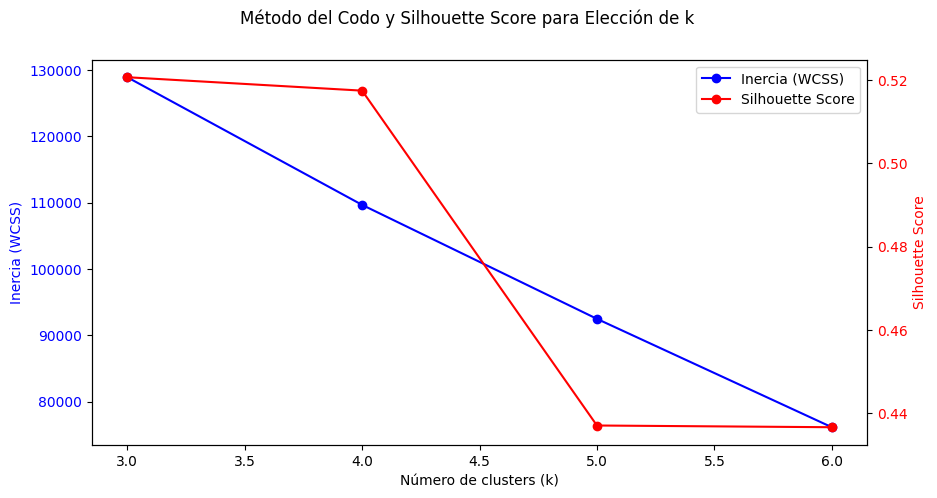

In [ ]:
# Selección de variables para clustering (solo comercios con ventas)
feature_columns = [
    "monto_promedio_mensual",
    "share_meses_activos",
    "n_terminales_max",
    "n_tecnologias_unicas",
    "margen_pct_volumen",
    "gap_pricing_mdr",
    "klap_mdr",
    "competidor_mdr",
    "share_visa",
    "share_mastercard",
]
mask_activos = merchant_pricing_base["monto_total_anual"] > 0
seg_dataset = merchant_pricing_base.loc[mask_activos, feature_columns].fillna(0)
scaler = StandardScaler()
seg_scaled = scaler.fit_transform(seg_dataset)

# Eleccion del numero óptimo de clusters (k) usando el método del codo
wcss = []
for k in range(3, 7):
    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    km.fit(seg_scaled)
    wcss.append({"k": k, "inercia": km.inertia_})
wc_ss_df = pd.DataFrame(wcss)

print("\n metodo del codo para eleccion de  k \n")
display(wc_ss_df)

# sillouette

silhouette_scores = []
for k in range(3, 7):
    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    cluster_labels = km.fit_predict(seg_scaled)
    silhouette_avg = silhouette_score(seg_scaled, cluster_labels)
    silhouette_scores.append({"k": k, "silhouette_score": silhouette_avg})
silhouette_df = pd.DataFrame(silhouette_scores)
print("\n silhouette scores para eleccion de k \n")
display(silhouette_df)
# plot de codo y silhouette


fig, ax1 = plt.subplots(figsize=(10, 5))
ax2 = ax1.twinx()
ax1.plot(
    wc_ss_df["k"], wc_ss_df["inercia"], marker="o", color="b", label="Inercia (WCSS)"
)
ax2.plot(
    silhouette_df["k"],
    silhouette_df["silhouette_score"],
    marker="o",
    color="r",
    label="Silhouette Score",
)
ax1.set_xlabel("Número de clusters (k)")
ax1.set_ylabel("Inercia (WCSS)", color="b")
ax2.set_ylabel("Silhouette Score", color="r")
ax1.tick_params(axis="y", labelcolor="b")
ax2.tick_params(axis="y", labelcolor="r")
fig.suptitle("Método del Codo y Silhouette Score para Elección de k")
fig.legend(loc="upper right", bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)
plt.show()


Elegimos `k = 4` como equilibrio entre granularidad y estabilidad (criterio tipo elbow).

El salto de 3→4 clusters reduce la inercia de 128 873.78 a 109 643.51 (−19 230), el ajuste más significativo en el rango evaluado. De 4→5 solo cae otros 17 167 puntos y de 5→6 disminuye 16 324; la ganancia marginal se atenúa, por lo que cada cluster adicional aporta menos separación relativa.

Más segmentos implican mayor complejidad operativa (más reglas comerciales y riesgo de sobresegmentación) sin mejoras proporcionales en inercia, así que `k = 4` preserva un buen balance entre granularidad y estabilidad.

In [ ]:
# Aplicar K-means con k=4 y asignar segmentos
k_optimo = 4
kmeans = KMeans(n_clusters=k_optimo, random_state=42, n_init=20)
clusters = kmeans.fit_predict(seg_scaled)
merchant_pricing_base.loc[mask_activos, "segmento_cluster"] = clusters
merchant_pricing_base["segmento_cluster"] = (
    merchant_pricing_base["segmento_cluster"].fillna(-1).astype(int)
)

cluster_summary = (
    merchant_pricing_base.loc[mask_activos]
    .groupby("segmento_cluster")
    .agg(
        n_comercios=("rut_comercio", "count"),
        monto_prom_mensual=("monto_promedio_mensual", "median"),
        margen_pct_medio=("margen_pct_volumen", "median"),
        margen_estimado_millones=("margen_estimado", lambda s: s.sum() / 1e6),
        share_activos_medio=("share_meses_activos", "median"),
        gap_mdr_medio=("gap_pricing_mdr", "median"),
        n_terminales_medio=("n_terminales_max", "median"),
    )
    .sort_values("monto_prom_mensual", ascending=False)
)
print("\n Resumen de los segmentos (0,1,2,3) K=4 \n")
display(cluster_summary)



 Resumen de los segmentos (0,1,2,3) K=4 



,n_comercios,monto_prom_mensual,margen_pct_medio,margen_estimado_millones,share_activos_medio,gap_mdr_medio,n_terminales_medio
segmento_cluster,,,,,,,
2,18,"2,360,490,297.42",0.01,"94,667.00",1.00,-0.00,387.50
1,5080,"18,058,166.30",0.01,"43,724.83",1.00,-0.00,2.00
0,17391,"550,485.45",0.02,"4,611.72",0.75,-0.00,1.00
3,1736,"2,390.91",0.04,-6.40,0.25,-0.00,1.00


In [ ]:
# Asignación de etiquetas descriptivas según patrones observados
vol_high = merchant_pricing_base.loc[mask_activos, "monto_promedio_mensual"].quantile(
    0.75
)
vol_low = merchant_pricing_base.loc[mask_activos, "monto_promedio_mensual"].quantile(
    0.25
)
margin_low = merchant_pricing_base.loc[mask_activos, "margen_pct_volumen"].quantile(
    0.25
)
gap_high = merchant_pricing_base.loc[mask_activos, "gap_pricing_mdr"].quantile(0.75)

labels = {}
for cluster_id, row in cluster_summary.iterrows():
    if row["margen_estimado_millones"] <= 0:
        labels[cluster_id] = "Margen en riesgo"
    elif row["gap_mdr_medio"] >= gap_high:
        labels[cluster_id] = "Brecha competitiva"
    elif row["monto_prom_mensual"] >= vol_high and row["margen_pct_medio"] > margin_low:
        labels[cluster_id] = "Alta contribución"
    elif row["share_activos_medio"] < 0.4 or row["monto_prom_mensual"] <= vol_low:
        labels[cluster_id] = "Baja actividad"
    else:
        labels[cluster_id] = "Optimización gradual"
cluster_summary["etiqueta_cluster"] = cluster_summary.index.map(labels)
display(cluster_summary)

merchant_pricing_base["segmento_cluster_label"] = (
    merchant_pricing_base["segmento_cluster"].map(labels).fillna("Sin ventas")
)

segmento_counts = merchant_pricing_base["segmento_cluster_label"].value_counts()


print("\n Conteo de comercios por segmento de cluster \n")
display(segmento_counts)


,n_comercios,monto_prom_mensual,margen_pct_medio,margen_estimado_millones,share_activos_medio,gap_mdr_medio,n_terminales_medio,etiqueta_cluster
segmento_cluster,,,,,,,,
2,18,"2,360,490,297.42",0.01,"94,667.00",1.00,-0.00,387.50,Alta contribución
1,5080,"18,058,166.30",0.01,"43,724.83",1.00,-0.00,2.00,Alta contribución
0,17391,"550,485.45",0.02,"4,611.72",0.75,-0.00,1.00,Brecha competitiva
3,1736,"2,390.91",0.04,-6.40,0.25,-0.00,1.00,Margen en riesgo



 Conteo de comercios por segmento de cluster 



segmento_cluster_label
Sin ventas            51057
Brecha competitiva    17391
Alta contribución      5098
Margen en riesgo       1736
Name: count, dtype: int64

In [ ]:
# Guardamos segmentación
segmentation_summary = cluster_summary.reset_index().rename(
    columns={"segmento_cluster": "cluster_id"}
)

print(" \nResumen de la segmentación de comercios \n")

display(segmentation_summary)

# Cruce entre clusters y acción sugerida para priorizar iniciativas
cluster_action_summary = (
    merchant_pricing_base.groupby(["segmento_cluster_label", "accion_sugerida"])
    .agg(
        n_comercios=("rut_comercio", "count"),
        monto_total_anual=("monto_total_anual", "sum"),
        margen_estimado=("margen_estimado", "sum"),
    )
    .sort_values(
        ["segmento_cluster_label", "monto_total_anual"], ascending=[True, False]
    )
)

print("\n Resumen de acciones sugeridas por segmento de comercio \n")

display(cluster_action_summary)


 
Resumen de la segmentación de comercios 



,cluster_id,n_comercios,monto_prom_mensual,margen_pct_medio,margen_estimado_millones,share_activos_medio,gap_mdr_medio,n_terminales_medio,etiqueta_cluster
0,2,18,"2,360,490,297.42",0.01,"94,667.00",1.00,-0.00,387.50,Alta contribución
1,1,5080,"18,058,166.30",0.01,"43,724.83",1.00,-0.00,2.00,Alta contribución
2,0,17391,"550,485.45",0.02,"4,611.72",0.75,-0.00,1.00,Brecha competitiva
3,3,1736,"2,390.91",0.04,-6.40,0.25,-0.00,1.00,Margen en riesgo



 Resumen de acciones sugeridas por segmento de comercio 



n_comercios  \
segmento_cluster_label accion_sugerida                            
Alta contribución      Mantener / Upsell servicios         5054   
                       Ajustar MDR urgente                   32   
                       Monitorear baja actividad             12   
Brecha competitiva     Mantener / Upsell servicios        14501   
                       Monitorear baja actividad           2890   
Margen en riesgo       Ajustar MDR urgente                   95   
                       Mantener / Upsell servicios         1014   
                       Monitorear baja actividad            627   
Sin ventas             Reactivación comercial             51057   

                                                       monto_total_anual  \
segmento_cluster_label accion_sugerida                                     
Alta contribución      Mantener / Upsell servicios 16,833,263,056,398.00   
                       Ajustar MDR urgente             15,094,354,608.00   
                       Monitorear baja actividad        6,686,539,129.00   
Brecha competitiva     Mantener / Upsell servicios    278,121,530,278.00   
                       Monitorear baja actividad        4,155,652,584.00   
Margen en riesgo       Ajustar MDR urgente             21,327,111,414.00   
                       Mantener / Upsell servicios      1,337,609,972.00   
                       Monitorear baja actividad          146,908,848.00   
Sin ventas             Reactivación comercial                       0.00   

                                                      margen_estimado  
segmento_cluster_label accion_sugerida                                 
Alta contribución      Mantener / Upsell servicios 138,366,791,950.15  
                       Ajustar MDR urgente              -2,132,173.58  
                       Monitorear baja actividad        27,167,158.95  
Brecha competitiva     Mantener / Upsell servicios   4,558,864,873.30  
                       Monitorear baja actividad        52,857,960.41  
Margen en riesgo       Ajustar MDR urgente             -13,127,181.22  
                       Mantener / Upsell servicios       6,375,367.66  
                       Monitorear baja actividad           347,451.66  
Sin ventas             Reactivación comercial                    0.00

## 🔄 MEJORA: Segmentación Estratégica 2D

**Mejoras implementadas:**

1. **Mayor granularidad**: 4 → 6 clusters para capturar mejor la diversidad de comercios
2. **Etiquetas accionables**: Nombres que comunican claramente la estrategia (Champions, Potencial Alto, etc.)
3. **Matriz 2D**: Combina comportamiento (6 tipos) x tamaño (5 niveles) = 30 micro-segmentos
4. **Segmentos estratégicos**: Identifica automáticamente el 20% que genera el 80% del valor
5. **Estrategia integrada**: Cada segmento tiene asociada una acción comercial específica

**Valor agregado:**
- ✅ Personalización más fina sin perder simplicidad operativa
- ✅ Priorización basada en regla de Pareto (80/20)
- ✅ Estrategias comerciales claras y accionables
- ✅ Fácil integración con herramientas de BI y CRM


In [ ]:
# ============================================================================
# NUEVA SEGMENTACIÓN MEJORADA: Matriz 2D Estratégica (6x5 = 30 micro-segmentos)
# ============================================================================

print("\n" + "=" * 80)
print("  MEJORA DE SEGMENTACIÓN: De 4 clusters básicos a Matriz Estratégica 2D")
print("=" * 80 + "\n")

# -----------------------------------------------------------------------------
# PASO 1: Aumentar granularidad de clustering (4 → 6 clusters)
# -----------------------------------------------------------------------------
print("📊 PASO 1: Re-clustering con 6 clusters para mayor granularidad\n")

k_mejorado = 6
kmeans_mejorado = KMeans(n_clusters=k_mejorado, random_state=42, n_init=20)
clusters_mejorado = kmeans_mejorado.fit_predict(seg_scaled)

# Asignar nuevos clusters
merchant_pricing_base.loc[mask_activos, "segmento_cluster_6"] = clusters_mejorado
merchant_pricing_base["segmento_cluster_6"] = (
    merchant_pricing_base["segmento_cluster_6"].fillna(-1).astype(int)
)

# Resumen estadístico de los 6 clusters
cluster_summary_6 = (
    merchant_pricing_base.loc[mask_activos]
    .groupby("segmento_cluster_6")
    .agg(
        n_comercios=("rut_comercio", "count"),
        monto_prom_mensual=("monto_promedio_mensual", "mean"),
        monto_total_millones=("monto_total_anual", lambda x: x.sum() / 1e6),
        share_activos_medio=("share_meses_activos", "mean"),
        margen_pct_medio=("margen_pct_volumen", "mean"),
        margen_estimado_millones=("margen_estimado", lambda x: x.sum() / 1e6),
        gap_mdr_medio=("gap_pricing_mdr", "mean"),
        n_terminales_promedio=("n_terminales_max", "mean"),
        klap_mdr_medio=("klap_mdr", "mean"),
    )
)

print(f"✅ Clustering completado: {k_mejorado} clusters creados")
print(f"   Total comercios activos: {mask_activos.sum():,}\n")

# -----------------------------------------------------------------------------
# PASO 2: Asignación de etiquetas mejoradas (más granulares y accionables)
# -----------------------------------------------------------------------------
print("🏷️  PASO 2: Asignación de etiquetas estratégicas\n")

# Umbrales dinámicos basados en distribución
vol_p75 = merchant_pricing_base.loc[mask_activos, "monto_promedio_mensual"].quantile(
    0.75
)
vol_p50 = merchant_pricing_base.loc[mask_activos, "monto_promedio_mensual"].quantile(
    0.50
)
vol_p25 = merchant_pricing_base.loc[mask_activos, "monto_promedio_mensual"].quantile(
    0.25
)

margin_p75 = merchant_pricing_base.loc[mask_activos, "margen_pct_volumen"].quantile(
    0.75
)
margin_p50 = merchant_pricing_base.loc[mask_activos, "margen_pct_volumen"].quantile(
    0.50
)
margin_p25 = merchant_pricing_base.loc[mask_activos, "margen_pct_volumen"].quantile(
    0.25
)

gap_p75 = merchant_pricing_base.loc[mask_activos, "gap_pricing_mdr"].quantile(0.75)
gap_p25 = merchant_pricing_base.loc[mask_activos, "gap_pricing_mdr"].quantile(0.25)

actividad_baja = 0.3  # <30% meses activos

labels_mejorado = {}
icons_segmento = {}
estrategia_segmento = {}

for cluster_id, row in cluster_summary_6.iterrows():
    vol = row["monto_prom_mensual"]
    margin = row["margen_pct_medio"]
    gap = row["gap_mdr_medio"]
    actividad = row["share_activos_medio"]
    margen_total = row["margen_estimado_millones"]

    # Reglas jerarquizadas (más específicas primero)

    # 1. CHAMPIONS: Alto volumen + Alto margen + Alta actividad
    if vol >= vol_p75 and margin >= margin_p75 and actividad >= 0.7:
        labels_mejorado[cluster_id] = "Champions"
        icons_segmento[cluster_id] = "⭐"
        estrategia_segmento[cluster_id] = "Mantener + Upsell premium"

    # 2. EN RIESGO CRÍTICO: Margen negativo
    elif margen_total <= 0:
        labels_mejorado[cluster_id] = "En Riesgo Crítico"
        icons_segmento[cluster_id] = "🚨"
        estrategia_segmento[cluster_id] = "Ajuste urgente o descontinuar"

    # 3. POTENCIAL ALTO: Alto volumen pero bajo margen (oportunidad)
    elif vol >= vol_p75 and margin < margin_p25:
        labels_mejorado[cluster_id] = "Potencial Alto"
        icons_segmento[cluster_id] = "🚀"
        estrategia_segmento[cluster_id] = "Optimizar pricing urgente"

    # 4. BRECHA COMPETITIVA: Gap alto vs competencia
    elif gap >= gap_p75 and gap > 0.0015:  # >15 bps
        labels_mejorado[cluster_id] = "Brecha Competitiva"
        icons_segmento[cluster_id] = "⚠️"
        estrategia_segmento[cluster_id] = "Ajustar a mercado"

    # 5. LEALES RENTABLES: Volumen medio-alto + margen alto + muy activos
    elif vol >= vol_p50 and margin >= margin_p50 and actividad >= 0.6:
        labels_mejorado[cluster_id] = "Leales Rentables"
        icons_segmento[cluster_id] = "💎"
        estrategia_segmento[cluster_id] = "Retener + Cross-sell"

    # 6. INACTIVOS CON POTENCIAL: Baja actividad pero con volumen cuando opera
    elif actividad < actividad_baja and vol >= vol_p25:
        labels_mejorado[cluster_id] = "Inactivos Potencial"
        icons_segmento[cluster_id] = "😴"
        estrategia_segmento[cluster_id] = "Reactivación + Incentivos"

    # 7. BÁSICOS: Volumen bajo + margen estándar
    elif vol < vol_p25 and margin >= margin_p25:
        labels_mejorado[cluster_id] = "Básicos Estables"
        icons_segmento[cluster_id] = "📊"
        estrategia_segmento[cluster_id] = "Mantener tarifas estándar"

    # 8. DEFAULT (resto)
    else:
        labels_mejorado[cluster_id] = "Optimización Gradual"
        icons_segmento[cluster_id] = "🔧"
        estrategia_segmento[cluster_id] = "Monitoreo + Ajustes selectivos"

# Aplicar etiquetas
cluster_summary_6["etiqueta_segmento"] = cluster_summary_6.index.map(labels_mejorado)
cluster_summary_6["icono"] = cluster_summary_6.index.map(icons_segmento)
cluster_summary_6["estrategia"] = cluster_summary_6.index.map(estrategia_segmento)

merchant_pricing_base["segmento_comportamiento"] = (
    merchant_pricing_base["segmento_cluster_6"]
    .map(labels_mejorado)
    .fillna("Sin ventas")
)

merchant_pricing_base["estrategia_comercial"] = (
    merchant_pricing_base["segmento_cluster_6"]
    .map(estrategia_segmento)
    .fillna("Reactivar cliente")
)

print("✅ Etiquetas asignadas a 6 clusters\n")

# -----------------------------------------------------------------------------
# PASO 3: Segmentación por tamaño (5 niveles en lugar de 4)
# -----------------------------------------------------------------------------
print("📏 PASO 3: Segmentación por tamaño (5 niveles)\n")

segment_bins_mejorado = [
    0,
    5_000_000,
    15_000_000,
    40_000_000,
    100_000_000,
    float("inf"),
]
segment_labels_mejorado = ["Estándar", "PRO", "PRO Max", "Enterprise", "Corporativo"]

merchant_pricing_base["segmento_tamaño"] = pd.cut(
    merchant_pricing_base["monto_promedio_mensual"],
    bins=segment_bins_mejorado,
    labels=segment_labels_mejorado,
    include_lowest=True,
).astype(str)

print("✅ Segmentación por tamaño completada")
print("   Rangos ajustados para mayor granularidad:\n")
for i, label in enumerate(segment_labels_mejorado):
    rango_min = (
        f"${segment_bins_mejorado[i] / 1e6:.1f}MM"
        if segment_bins_mejorado[i] > 0
        else "$0"
    )
    rango_max = (
        f"${segment_bins_mejorado[i + 1] / 1e6:.1f}MM"
        if segment_bins_mejorado[i + 1] != float("inf")
        else "+∞"
    )
    print(f"   • {label:12s}: {rango_min:10s} - {rango_max}")

# -----------------------------------------------------------------------------
# PASO 4: Crear Matriz 2D (Comportamiento x Tamaño)
# -----------------------------------------------------------------------------
print("\n🎯 PASO 4: Creación de Matriz Estratégica 2D\n")

# Crear segmento combinado
merchant_pricing_base["segmento_matriz_2d"] = (
    merchant_pricing_base["segmento_comportamiento"]
    + " - "
    + merchant_pricing_base["segmento_tamaño"]
)

# Análisis de la matriz
matriz_segmentacion = (
    merchant_pricing_base[merchant_pricing_base["monto_total_anual"] > 0]
    .groupby(["segmento_comportamiento", "segmento_tamaño"])
    .agg(
        n_comercios=("rut_comercio", "count"),
        volumen_total_mm=("monto_total_anual", lambda x: x.sum() / 1e6),
        margen_total_mm=("margen_estimado", lambda x: x.sum() / 1e6),
        margen_pct_promedio=("margen_pct_volumen", "mean"),
    )
    .reset_index()
)

# Calcular % de volumen y margen
total_vol = matriz_segmentacion["volumen_total_mm"].sum()
total_margin = matriz_segmentacion["margen_total_mm"].sum()

matriz_segmentacion["vol_share_pct"] = (
    matriz_segmentacion["volumen_total_mm"] / total_vol * 100
)
matriz_segmentacion["margin_share_pct"] = (
    matriz_segmentacion["margen_total_mm"] / total_margin * 100
)

# Identificar segmentos estratégicos (Pareto: 80% del valor)
matriz_segmentacion = matriz_segmentacion.sort_values(
    "volumen_total_mm", ascending=False
).reset_index(drop=True)

matriz_segmentacion["vol_cumsum_pct"] = matriz_segmentacion["vol_share_pct"].cumsum()
matriz_segmentacion["es_estrategico"] = matriz_segmentacion["vol_cumsum_pct"] <= 80

print(f"✅ Matriz 2D creada: {len(matriz_segmentacion)} micro-segmentos activos")
print(f"   Total volumen: ${total_vol:,.0f}MM")
print(f"   Total margen: ${total_margin:,.1f}MM\n")

# -----------------------------------------------------------------------------
# PASO 5: Visualización del resumen
# -----------------------------------------------------------------------------
print("=" * 80)
print("  RESUMEN DE SEGMENTACIÓN MEJORADA")
print("=" * 80 + "\n")

print("📊 Distribución por Comportamiento (6 clusters):\n")
display(
    cluster_summary_6[
        [
            "icono",
            "etiqueta_segmento",
            "n_comercios",
            "monto_total_millones",
            "margen_estimado_millones",
            "margen_pct_medio",
            "estrategia",
        ]
    ].sort_values("monto_total_millones", ascending=False)
)

print("\n📏 Distribución por Tamaño:\n")
dist_tamaño = (
    merchant_pricing_base[merchant_pricing_base["monto_total_anual"] > 0]
    .groupby("segmento_tamaño")
    .agg(
        n_comercios=("rut_comercio", "count"),
        volumen_mm=("monto_total_anual", lambda x: x.sum() / 1e6),
        margen_mm=("margen_estimado", lambda x: x.sum() / 1e6),
    )
)
display(dist_tamaño.sort_values("volumen_mm", ascending=False))

print("\n🎯 Top 10 Micro-Segmentos Estratégicos (Matriz 2D):\n")
display(
    matriz_segmentacion[
        [
            "segmento_comportamiento",
            "segmento_tamaño",
            "n_comercios",
            "volumen_total_mm",
            "margen_total_mm",
            "vol_share_pct",
            "es_estrategico",
        ]
    ].head(10)
)

print("\n" + "=" * 80)
print("✅ SEGMENTACIÓN MEJORADA COMPLETADA")
print("=" * 80)
print("\nPróximos pasos:")
print("1. Usar 'segmento_comportamiento' para estrategias comerciales")
print("2. Usar 'segmento_tamaño' para asignación de recursos")
print("3. Usar 'segmento_matriz_2d' para personalización granular")
print("4. Priorizar segmentos con 'es_estrategico' = True (regla 80/20)\n")


### Estrategia y justificación de la propuesta de pricing

El pipeline combina tres pilares para optimizar precios por segmento de comercio:
1. **Modelo financiero**: el cálculo de `margen_estimado` contrasta los ingresos actuales (MDR + fijo) contra el piso de costos (interchange y marca), identificando relaciones potencialmente deficitarias antes de que afecten resultados.
2. **Referente competitivo**: `gap_pricing_mdr` utiliza la tarifa efectiva de Transbank como benchmark, lo que permite detectar casos en los que la propuesta de Klap queda sobre el mercado sin respaldo en valor agregado.
3. **Segmentación basada en datos**: el clustering `segmento_cluster_label` agrupa comercios según volumen, actividad, tecnología y salud del margen, de modo que las decisiones (ajuste, reactivación, upsell) se tomen a nivel de arquetipo y no comercio por comercio.

El cruce `cluster_action_summary` muestra cómo se combinan los clusters con las acciones sugeridas, facilitando la definición de iniciativas concretas (por ejemplo, planes de retención para "Brecha competitiva" o programas de reactivación para "Baja actividad"). La metodología es robusta porque integra costos reales, competencia y comportamiento transaccional, lo que permite proponer ajustes de pricing sustentados en datos y escalables.

## **Identificación de riesgos + Sistema Recomendador**

El modelo clasifica a los comercios según sus características relevantes y gatilla alertas para aquellos con señales de fuga o donde Klap registra márgenes negativos.

Los hallazgos se despliegan en una interfaz tipo aplicación web (`webb_app_blabla.html`) que permite visualizar rápidamente segmentos o comercios críticos y los planes sugeridos a partir del análisis. Las recomendaciones abarcan cambios de planes, ofertas y acciones comerciales priorizadas según el comportamiento histórico de cada cliente.

Esta estrategia apunta a mejorar simultáneamente la rentabilidad y la retención, apoyándose en datos concretos y en las variables que explican el desempeño de los comercios.

In [ ]:
planes = [
    {
        "nombre": "Plan Estándar",
        "segmento_origen": "Estándar",
        "descripcion": "Tarifa oficial para comercios con ventas hasta 8 MM CLP mensuales.",
        "segmentos_objetivo_volumen": ["Estándar", "Sin ventas"],
        "segmentos_objetivo_cluster": [
            "Baja actividad",
            "Margen en riesgo",
            "Brecha competitiva",
        ],
    },
    {
        "nombre": "Plan PRO",
        "segmento_origen": "PRO",
        "descripcion": "Tarifa oficial PRO para comercios con 8-30 MM CLP mensuales.",
        "segmentos_objetivo_volumen": ["PRO", "Optimización gradual"],
        "segmentos_objetivo_cluster": ["Optimización gradual", "Brecha competitiva"],
    },
    {
        "nombre": "Plan PRO Max",
        "segmento_origen": "PRO Max",
        "descripcion": "Tarifa oficial PRO Max para comercios de alto volumen (>30 MM CLP).",
        "segmentos_objetivo_volumen": ["PRO Max", "Enterprise"],
        "segmentos_objetivo_cluster": ["Alta contribución"],
    },
]


def recomendar_plan(row):
    score_plan = []
    for plan in planes:
        score = 0
        if row.get("segmento_promedio_volumen") in plan["segmentos_objetivo_volumen"]:
            score += 2
        if row.get("segmento_cluster_label") in plan["segmentos_objetivo_cluster"]:
            score += 2
        if (
            row.get("monto_total_anual", 0) > 120_000_000
            and plan["nombre"] == "Plan PRO Max"
        ):
            score += 1
        if (
            row.get("monto_total_anual", 0) < 30_000_000
            and plan["nombre"] == "Plan Estándar"
        ):
            score += 1
        if row.get("margen_estimado", 0) <= 0:
            score -= 1
        score_plan.append((plan["nombre"], plan["mdr"], plan["fijo"], score))
    score_plan.sort(key=lambda x: x[3], reverse=True)
    best = score_plan[0]
    return {
        "plan_recomendado": best[0],
        "plan_mdr_propuesto": best[1],
        "plan_fijo_propuesto": best[2],
    }

Definimos un **catálogo** de planes base (fijos/variables) y add-ons asociados a reglas de segmentación ya calculadas. De esta forma es posible iterar sobre los comercios, asignar automáticamente un plan base con sus tasas oficiales y sugerir add-ons cuando se cumplen los criterios definidos.

In [ ]:
# Catálogo de planes y add-ons basado en la grilla oficial
segment_mix = segment_effective.set_index("Segmento")


for plan in planes:
    seg = plan["segmento_origen"]
    if seg not in segment_mix.index:
        raise KeyError(f"Segmento {seg} no encontrado en la grilla de precios oficial")
    plan["mdr"] = float(segment_mix.loc[seg, "mdr_effectivo"])
    plan["fijo"] = float(segment_mix.loc[seg, "fijo_effectivo"])

addons = [
    {
        "nombre": "Omnicanal Plus",
        "descripcion": "Incluye billeteras, QR, web checkout y soporte para marketplaces.",
        "fee_mensual": 35000,
        "criterio": lambda row: row.get("n_tecnologias_unicas", 0) < 2
        and row.get("monto_total_anual", 0) > 60_000_000,
    },
    {
        "nombre": "Insights & Fidelización",
        "descripcion": "Reportes avanzados, campañas de puntos y marketing SMS/Email.",
        "fee_mensual": 25000,
        "criterio": lambda row: row.get("share_meses_activos", 0) > 0.6
        and row.get("margen_estimado", 0) > 0,
    },
    {
        "nombre": "Pagos Internacionales",
        "descripcion": "Aceptación de tarjetas internacionales y pagos cross-border.",
        "fee_mensual": 45000,
        "criterio": lambda row: row.get("share_visa", 0) > 0.5
        and row.get("monto_total_anual", 0) > 120_000_000,
    },
]


In [ ]:
plan_df = merchant_pricing_base.apply(recomendar_plan, axis=1, result_type="expand")
print("\n Planes recomendados\n")
display(plan_df)

merchant_pricing_base = pd.concat([merchant_pricing_base, plan_df], axis=1)
print("\n ----- Tabla final con recomendaciones de planes y add-ons ---- \n")
display(merchant_pricing_base)



 Planes recomendados



,plan_recomendado,plan_mdr_propuesto,plan_fijo_propuesto
0,Plan Estándar,0.01,95.00
1,Plan PRO Max,0.01,82.60
2,Plan Estándar,0.01,95.00
3,Plan Estándar,0.01,95.00
4,Plan Estándar,0.01,95.00
...,...,...,...
75277,Plan Estándar,0.01,95.00
75278,Plan Estándar,0.01,95.00
75279,Plan Estándar,0.01,95.00
75280,Plan Estándar,0.01,95.00



 ----- Tabla final con recomendaciones de planes y add-ons ---- 



,rut_comercio,monto_total_anual,qtrx_total_anual,meses_reportados,meses_con_ventas,monto_promedio_mensual,monto_max_mensual,qtrx_promedio_mensual,ticket_promedio_mensual,n_locales_max,...,ingreso_competencia_variable,ingreso_competencia_fijo,ingreso_total_competencia,gap_pricing_mdr,accion_sugerida,segmento_cluster,segmento_cluster_label,plan_recomendado,plan_mdr_propuesto,plan_fijo_propuesto
0,07289970-9,0.00,0.00,11,0,0.00,0.00,0.00,NaN,1,...,0.00,0.00,0.00,-0.01,Reactivación comercial,-1,Sin ventas,Plan Estándar,0.01,95.00
1,10000001-6,"156,061,978.00","28,802.00",11,11,"14,187,452.55","19,680,080.00","2,618.36","5,420.65",1,...,"1,896,153.03",53.27,"1,896,206.30",-0.00,Mantener / Upsell servicios,1,Alta contribución,Plan PRO Max,0.01,82.60
2,10000058-K,0.00,0.00,12,0,0.00,0.00,0.00,NaN,1,...,0.00,0.00,0.00,-0.01,Reactivación comercial,-1,Sin ventas,Plan Estándar,0.01,95.00
3,10000217-5,0.00,0.00,12,0,0.00,0.00,0.00,NaN,2,...,0.00,0.00,0.00,-0.01,Reactivación comercial,-1,Sin ventas,Plan Estándar,0.01,95.00
4,10000372-4,"4,996,222.00","1,998.00",6,6,"832,703.67","995,680.00",333.00,"2,515.63",1,...,"60,704.10",3.70,"60,707.79",-0.00,Mantener / Upsell servicios,0,Brecha competitiva,Plan Estándar,0.01,95.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75277,9998724-3,0.00,0.00,12,0,0.00,0.00,0.00,NaN,1,...,0.00,0.00,0.00,-0.01,Reactivación comercial,-1,Sin ventas,Plan Estándar,0.01,95.00
75278,9999021-K,0.00,0.00,11,0,0.00,0.00,0.00,NaN,1,...,0.00,0.00,0.00,-0.01,Reactivación comercial,-1,Sin ventas,Plan Estándar,0.01,95.00
75279,9999409-6,"25,658,656.00","1,824.00",11,11,"2,332,605.09","3,803,256.00",165.82,"14,297.33",1,...,"311,752.67",3.37,"311,756.04",-0.00,Mantener / Upsell servicios,0,Brecha competitiva,Plan Estándar,0.01,95.00
75280,9999543-2,"71,303,480.00","16,054.00",12,12,"5,941,956.67","7,978,280.00","1,337.83","4,474.02",2,...,"866,337.28",29.69,"866,366.97",-0.00,Mantener / Upsell servicios,0,Brecha competitiva,Plan Estándar,0.01,95.00


- **Data base:** `segment_effective` se indexa por segmento para crear `segment_mix`, lo que facilita consultar los valores oficiales de MDR y fijo correspondientes.
- **Planes:** la lista `planes` describe cada plan comercial (Plan Estándar, Plan PRO, Plan PRO Max) con su segmento de origen, descripción y los segmentos (por volumen y cluster) a los que se ofrece.
- **Validación y precios:** cada plan toma de `segment_mix` los valores `mdr_effectivo` y `fijo_effectivo`, los convierte a `float` y los incorpora como `mdr` y `fijo`.
- **Catálogo de add-ons:** `addons` define servicios complementarios con nombre, descripción, cargo mensual (`fee_mensual`) y un criterio (función lambda) que evalúa si un comercio cumple las condiciones para ofrecerle el add-on.

In [ ]:
# Resumen de propuestas por plan recomendado
plan_summary = (
    merchant_pricing_base.groupby("plan_recomendado")
    .agg(
        comercios=("rut_comercio", "count"),
        volumen=("monto_total_anual", "sum"),
        margen=("margen_estimado", "sum"),
    )
    .sort_values("volumen", ascending=False)
)
plan_summary


,comercios,volumen,margen
plan_recomendado,,,
Plan PRO Max,3727,"16,757,914,005,546.00","136,974,433,088.21"
Plan Estándar,70186,"284,109,384,842.00","4,618,438,620.49"
Plan PRO,1369,"118,109,372,843.00","1,404,273,698.64"


In [ ]:
def recomendar_addons(row):
    sugeridos = []
    for addon in addons:
        try:
            aplica = addon["criterio"](row)
        except Exception:
            aplica = False
        if aplica:
            sugeridos.append(f"{addon['nombre']} (${addon['fee_mensual']:,})")
    return ", ".join(sugeridos) if sugeridos else "Sin add-ons sugeridos"


merchant_pricing_base["addons_recomendados"] = merchant_pricing_base.apply(
    recomendar_addons, axis=1
)


In [ ]:
# Resumen de add-ons sugeridos
addon_summary = (
    merchant_pricing_base["addons_recomendados"]
    .value_counts()
    .rename_axis("addons_recomendados")
    .to_frame("comercios")
)
addon_summary.head(10)


,comercios
addons_recomendados,
Sin add-ons sugeridos,60008
"Insights & Fidelización ($25,000)",10053
"Omnicanal Plus ($35,000), Insights & Fidelización ($25,000), Pagos Internacionales ($45,000)",2000
"Insights & Fidelización ($25,000), Pagos Internacionales ($45,000)",1491
"Omnicanal Plus ($35,000), Insights & Fidelización ($25,000)",1469
"Pagos Internacionales ($45,000)",100
"Omnicanal Plus ($35,000), Pagos Internacionales ($45,000)",83
"Omnicanal Plus ($35,000)",78


- **Plan vs. margen**: `plan_summary` revela qué planes concentran mayor volumen y margen, priorizando segmentos para renegociaciones o campañas.
- **Add-ons**: `addon_summary` dimensiona la demanda potencial de servicios complementarios (Omnicanal, Fidelización, Pagos internacionales).
- **Cluster + acción**: el cruce `cluster_action_summary` habilita scripts comerciales específicos para cada arquetipo (por ejemplo, ajustar MDR en "Brecha competitiva" o activar add-ons en "Alta contribución").

In [ ]:
# Guardamos tabla de propuestas comerciales
proposal_output = DATA_DIR / "processed" / "merchant_pricing_proposals.parquet"
merchant_pricing_base.to_parquet(proposal_output, index=False)
proposal_output


PosixPath('data/processed/merchant_pricing_proposals.parquet')

In [ ]:
# Guardar resultados del modelo para usos posteriores (dashboards, app, etc.)
pricing_model_output = DATA_DIR / "processed" / "merchant_pricing_model_results.parquet"
merchant_pricing_base.to_parquet(pricing_model_output, index=False)
pricing_model_output


PosixPath('data/processed/merchant_pricing_model_results.parquet')

In [ ]:
merchant_pricing_base

,rut_comercio,monto_total_anual,qtrx_total_anual,meses_reportados,meses_con_ventas,monto_promedio_mensual,monto_max_mensual,qtrx_promedio_mensual,ticket_promedio_mensual,n_locales_max,...,ingreso_competencia_fijo,ingreso_total_competencia,gap_pricing_mdr,accion_sugerida,segmento_cluster,segmento_cluster_label,plan_recomendado,plan_mdr_propuesto,plan_fijo_propuesto,addons_recomendados
0,07289970-9,0.00,0.00,11,0,0.00,0.00,0.00,NaN,1,...,0.00,0.00,-0.01,Reactivación comercial,-1,Sin ventas,Plan Estándar,0.01,95.00,Sin add-ons sugeridos
1,10000001-6,"156,061,978.00","28,802.00",11,11,"14,187,452.55","19,680,080.00","2,618.36","5,420.65",1,...,53.27,"1,896,206.30",-0.00,Mantener / Upsell servicios,1,Alta contribución,Plan PRO Max,0.01,82.60,"Omnicanal Plus ($35,000), Insights & Fidelizac..."
2,10000058-K,0.00,0.00,12,0,0.00,0.00,0.00,NaN,1,...,0.00,0.00,-0.01,Reactivación comercial,-1,Sin ventas,Plan Estándar,0.01,95.00,Sin add-ons sugeridos
3,10000217-5,0.00,0.00,12,0,0.00,0.00,0.00,NaN,2,...,0.00,0.00,-0.01,Reactivación comercial,-1,Sin ventas,Plan Estándar,0.01,95.00,Sin add-ons sugeridos
4,10000372-4,"4,996,222.00","1,998.00",6,6,"832,703.67","995,680.00",333.00,"2,515.63",1,...,3.70,"60,707.79",-0.00,Mantener / Upsell servicios,0,Brecha competitiva,Plan Estándar,0.01,95.00,"Insights & Fidelización ($25,000)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75277,9998724-3,0.00,0.00,12,0,0.00,0.00,0.00,NaN,1,...,0.00,0.00,-0.01,Reactivación comercial,-1,Sin ventas,Plan Estándar,0.01,95.00,Sin add-ons sugeridos
75278,9999021-K,0.00,0.00,11,0,0.00,0.00,0.00,NaN,1,...,0.00,0.00,-0.01,Reactivación comercial,-1,Sin ventas,Plan Estándar,0.01,95.00,Sin add-ons sugeridos
75279,9999409-6,"25,658,656.00","1,824.00",11,11,"2,332,605.09","3,803,256.00",165.82,"14,297.33",1,...,3.37,"311,756.04",-0.00,Mantener / Upsell servicios,0,Brecha competitiva,Plan Estándar,0.01,95.00,"Insights & Fidelización ($25,000)"
75280,9999543-2,"71,303,480.00","16,054.00",12,12,"5,941,956.67","7,978,280.00","1,337.83","4,474.02",2,...,29.69,"866,366.97",-0.00,Mantener / Upsell servicios,0,Brecha competitiva,Plan Estándar,0.01,95.00,"Insights & Fidelización ($25,000)"


In [ ]:
merchant_pricing_base.isna().sum()

rut_comercio              0
monto_total_anual         0
qtrx_total_anual          0
meses_reportados          0
meses_con_ventas          0
                         ..
segmento_cluster_label    0
plan_recomendado          0
plan_mdr_propuesto        0
plan_fijo_propuesto       0
addons_recomendados       0
Length: 61, dtype: int64

In [ ]:
cols_num = merchant_pricing_base.select_dtypes(include="number")
zero_counts = (cols_num == 0).sum().sort_values(ascending=False)
display(zero_counts.to_frame(name="ceros"))


,ceros
costo_marca_hites,75282
costo_marca_ripley,75282
costo_marca_vale_electronico,75282
costo_marca_casas_comerciales,75282
costo_marca_amex,75282
monto_ripley,75282
monto_vale_electronico,75282
monto_hites,74774
monto_casas_comerciales,74774
monto_amex,72748


## **Próximos pasos**
1. Evaluar los márgenes actuales versus los costos mínimos por segmento (`segmento_promedio_volumen`) para detectar clientes con holgura o déficit.
2. Incorporar precios vigentes por comercio (cuando estén disponibles) y estimar margen real vs. piso de costo para validar oportunidades de ajuste.
3. Diseñar estrategias de reactivación para terminales inactivos considerando tecnología instalada y potencial de volumen.
4. Contrastar la propuesta actual con las tarifas de competidores para cuantificar riesgos de fuga y oportunidades de upsell.